In [1]:
import numpy as np
import dolfin as dl
from ufl import lhs, rhs, replace
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla
import matplotlib.pyplot as plt
from pathlib import Path
from nalger_helper_functions import *
import meshio
import sys
from scipy.spatial import KDTree as scipy_KDTree
from scipy.optimize import root_scalar
from localpsf import localpsf_root
from localpsf.newtoncg import newtoncg_ls, cgsteihaug
from localpsf.newtongmres import newtongmres_ls
from nalger_helper_functions import *

import hlibpro_python_wrapper as hpro
import localpsf.localpsf_cg1_lumped as lpsf
import localpsf.bilaplacian_regularization_lumped as blreg
from localpsf.derivatives_at_point import DerivativesAtPoint
from localpsf.inverse_problem_objective import InverseProblemObjective, finite_difference_check, PSFHessianPreconditioner #, InverseProblemPSFHessianPreconditioner
from localpsf.morozov_discrepancy import compute_morozov_regularization_parameter
from localpsf.stokes_mesh import make_stokes_meshes
from localpsf.stokes_function_spaces import make_stokes_function_spaces
from localpsf.stokes_variational_forms import stokes_inverse_problem_unregularized, load_stokes_parameter, check_stokes_gauss_newton_hessian, make_stokes_universe

# Options

In [8]:
all_noise_levels = list(np.logspace(np.log10(1e-2), np.log10(2.5e-1), 5)[::-1])

num_batches = 5 # number of batches used for Newton solves
tau = 3.0
num_neighbors = 10
hmatrix_tol = 1e-6
newton_rtol = 1e-8
# gamma_morozov = 15428.012899090285 # medium mesh, noise_level=1e-2
# gamma_morozov= 6932.714344119822 # fine mesh, noise_level=1e-2
# gamma_morozov= 6975.784285975133 # fine mesh, noise_level=1e-2
gamma_morozov = None
forcing_sequence_power = 0.5 # 1.0
num_gn_iter = 5

run_finite_difference_checks = True
check_gauss_newton_hessian = True

all_num_batches = [1, 5, 25] # number of batches used for spectral comparisons

In [3]:
save_dir = localpsf_root / 'numerical_examples' / 'stokes' / 'data' / 'stokes_deflation'
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_str = str(save_dir)

Solving forward problem with true parameter to get true observations
Solving forward problem with initial guess to reset
noise_level= 0.05 , noise_datanorm= 1266.854450132621
prior_correlation_length= 5000.0
Making row and column cluster trees
Making block cluster trees
  matrix has dimension 1416 x 1416
    no of non-zeroes    = 26820
    matrix is             real valued
    format              = non symmetric
  size of sparse matrix = 430.30 kB
  |S|_F                 = 0.00569474
    sparsity constant = 20
    size of H-matrix  = 4.06 MB
    |A|_F             = 0.00569474
 |S-A|_2 = 9.98034e-09
relerr_invCL_hmatrix= 3.4161101532945254e-13


/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)



━━ LU factorisation ( rtol = 1e-07 )
    done in 7.88s
    size of LU factor = 4.84 MB


Running finite difference check of Stokes objective. areg_ini= 1000000000.0
s= 1.0
err_grad_d= 3.264614183625946 , err_grad_r= 1.1166665767686719 , err_grad= 3.4026170201006747
err_hess_d= 0.26615829851730965 , err_hess_r= 9.568024674197087e-15 , err_hess= 0.2657511991664071
s= 0.1
err_grad_d= 0.07653388539126388 , err_grad_r= 22.333692931183162 , err_grad= 0.07739167808495329
err_hess_d= 0.030543070143759603 , err_hess_r= 1.055338042094184e-13 , err_hess= 0.0304844579156139
s= 0.01
err_grad_d= 0.007083453350747307 , err_grad_r= 0.1058452624431673 , err_grad= 0.007158531746754101
err_hess_d= 0.0030953168331394067 , err_hess_r= 1.048140490608445e-12 , err_hess= 0.0030892522950759977
s= 0.001
err_grad_d= 0.0007024061217934561 , err_grad_r= 0.0096639328839817 , err_grad= 0.0007098198353067772
err_hess_d= 0.00031005915931776564 , err_hess_r= 1.0127824366086992e-11 , err_hess= 0.0003094504240284875
s= 0.0001
err_grad_d= 7.026527525073924e-05 , err_grad_r= 0.0009580604333885246 , err_grad= 7

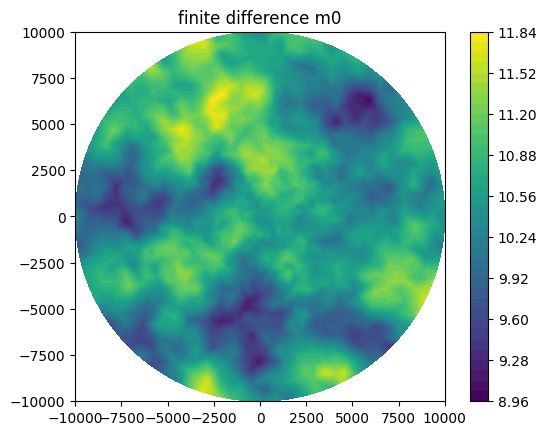

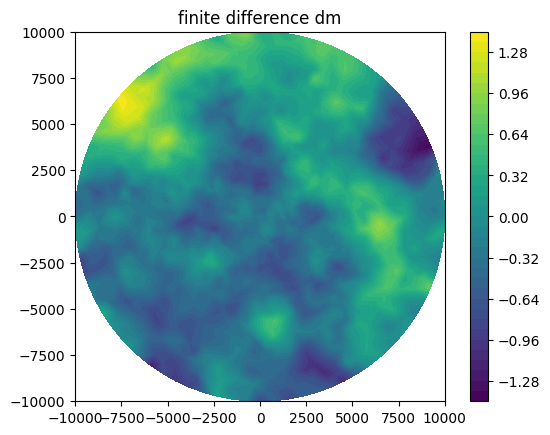

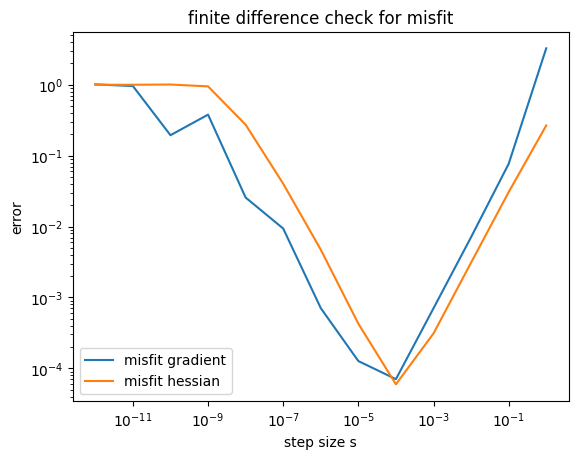

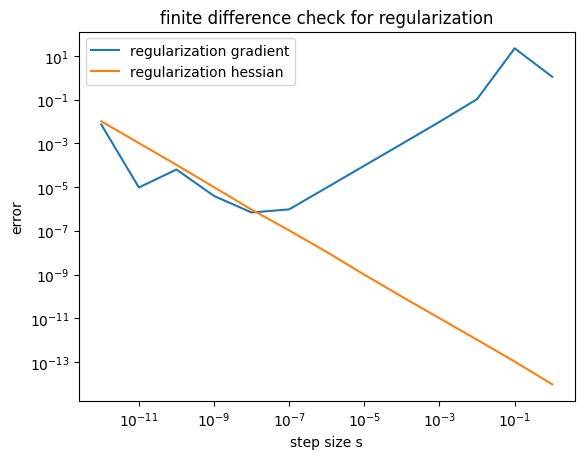

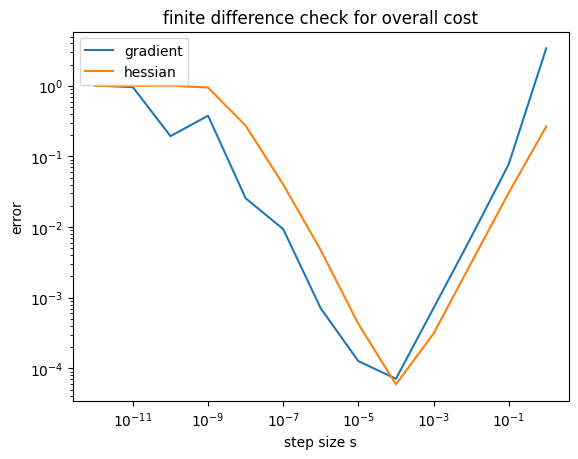

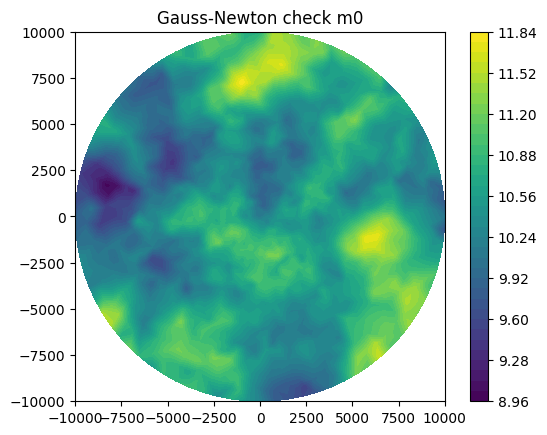

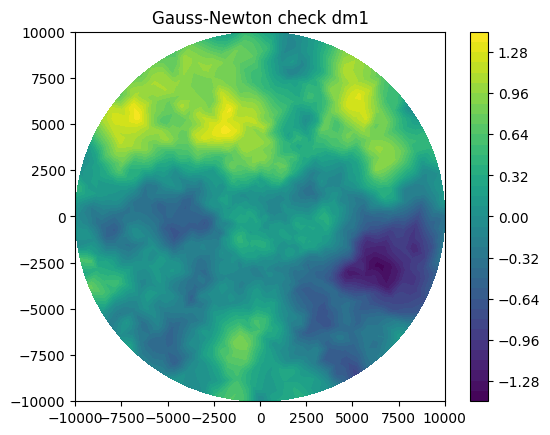

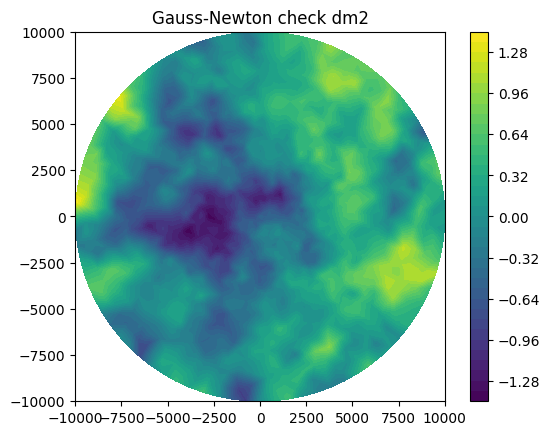

In [4]:
SU = make_stokes_universe(
    display=True,
    run_finite_difference_checks=run_finite_difference_checks,
    check_gauss_newton_hessian=check_gauss_newton_hessian)

In [5]:
# Save mesh
dl.File(save_dir_str + "/ice_mountain_mesh3D.xml") << SU.unregularized_inverse_problem.meshes.ice_mesh_3d
dl.File(save_dir_str + "/ice_mountain_mesh_base3D.xml") << SU.unregularized_inverse_problem.meshes.basal_mesh_3d
dl.File(save_dir_str + "/ice_mountain_mesh_base2D.xml") << SU.unregularized_inverse_problem.meshes.basal_mesh_2d

In [6]:
SU.unregularized_inverse_problem.meshes.ice_mesh_3d

Text(0.5, 1.0, '2D Basal Mesh')

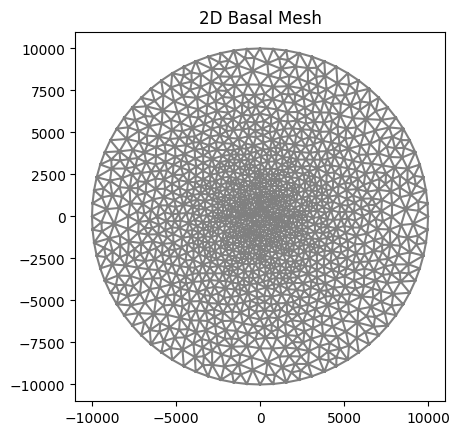

In [7]:
dl.plot(SU.unregularized_inverse_problem.meshes.basal_mesh_2d)
plt.title('2D Basal Mesh')

Text(0.5, 1.0, 'True parameter')

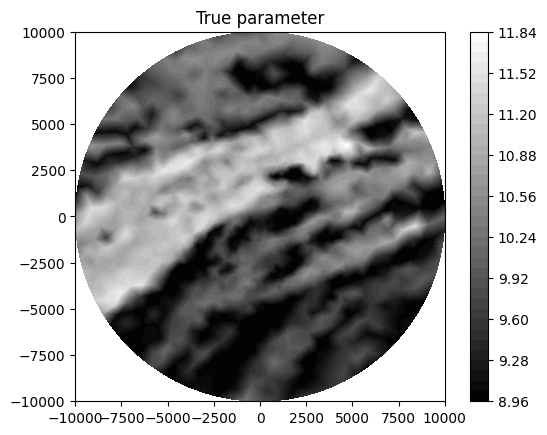

In [10]:
cm = dl.plot(SU.unregularized_inverse_problem.mtrue_Vh2(), cmap='gray')
plt.colorbar(cm)
plt.title('True parameter')

Text(0.5, 1.0, 'Parameter initial guess')

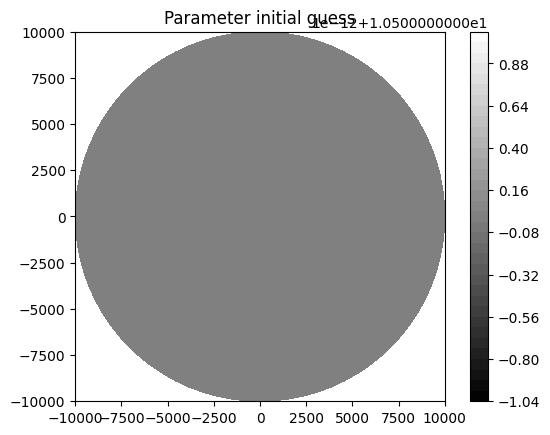

In [10]:
m0_Vh2 = dl.Function(SU.unregularized_inverse_problem.function_spaces.Vh2)
m0_Vh2.vector()[:] = SU.unregularized_inverse_problem.m_Vh2().vector()[:]

cm = dl.plot(m0_Vh2, cmap='gray')
plt.colorbar(cm)
plt.title('Parameter initial guess')

# Plots to make (2):
 - True velocity (arrows or not, up to you)
 - mtrue (basal sliding friction field)

In [11]:
dl.File(save_dir_str + "/mtrue_Vh2.pvd") << SU.unregularized_inverse_problem.mtrue_Vh2()
dl.File(save_dir_str + "/mtrue_Vh3.pvd") << SU.unregularized_inverse_problem.mtrue_Vh2()

dl.File(save_dir_str + "/true_velocity" + str(outflow_constant)+".pvd") << SU.unregularized_inverse_problem.velocity_true()
dl.File(save_dir_str + "/true_pressure" + str(outflow_constant)+".pvd") << SU.unregularized_inverse_problem.pressure_true()

# Compute Morozov regularization parameter for variety of noise levels

noise_level= 0.25 noise_datanorm= 22365.2440365536
Initial Guess.

----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 1000000000.0
newton_rtol 1e-06
num_gn_iter= 5
preconditioner_build_iters= (3,)
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 6.808e+06
||M r0|| = 6.808e+06
(M r0, r0) = 6.808e+06
 Iteration :  0  (r, r) =  46343219305625.055
 Iteration :  1  (r, r) =  18142275395804.414
 Iteration :  2  (r, r) =  8313008714513.635
 Iteration :  3  (r, r) =  2730937920499.927
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  1652554.967467021

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line

using Gauss-Newton Hessian
it= 3 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
building preconditioner
building psf object
Preparing c++ object
Building initial sample point batches


  0%|          | 0/5 [00:00<?, ?it/s]

/home/nick/repos/localpsf/localpsf/sample_point_batches.py:94: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :],


Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = 1e-07 )
              Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
    done in 9.57s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.52s                                                
    size of LU factor = 5.11 MB
32  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 16.28s                                                
    size of LU factor = 5.04 MB
9  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 15.75s                                                
    size of LU factor = 5.04 MB
5  /  50  eigs found                                             

━━ LU factori

using Hessian
it= 5 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 1000000000.0, 12505969806.648392)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 3.446e+03
||M r0|| = 2.020e-02
(M r0, r0) = 7.635e+00
 Iteration :  0  (r, r) =  11877909.008652724
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 1000000000.0, 12505969806.648392)
 Iteration :  1  (r, r) =  1413771.9137845312
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 1000000000.0, 12505969806.648392)
 Iteration :  2  (r, r) =  198333.69767786242
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 1000000000.0, 12505969806.648392)
 Iteration :  3  (r, r) =  24433.83019082719
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 1000000000.0, 12505969806.648392)
 Iteration :  4  (r, r) =  270

using Gauss-Newton Hessian
it= 1 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 10000000000.0, 12505969806.648392)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 9.856e+05
||M r0|| = 1.794e+00
(M r0, r0) = 1.098e+03
 Iteration :  0  (r, r) =  971505024706.5745
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 10000000000.0, 12505969806.648392)
 Iteration :  1  (r, r) =  20954516032.701286
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (500243124.97147393, 10000000000.0, 12505969806.648392)
 Iteration :  2  (r, r) =  900359700.6402311
Relative/Absolute residual less than tol
Converged in  2  iterations with final norm  30005.99441178764

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gr

using Hessian
it= 4 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

using Hessian
it= 3 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 100000000000.0, 312526408468.7182)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 9.381e+03
||M r0|| = 7.505e-03
(M r0, r0) = 6.347e+00
 Iteration :  0  (r, r) =  88005674.28644381
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 100000000000.0, 312526408468.7182)
 Iteration :  1  (r, r) =  8211055.742866278
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 100000000000.0, 312526408468.7182)
 Iteration :  2  (r, r) =  346050.1523509646
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 100000000000.0, 312526408468.7182)
 Iteration :  3  (r, r) =  21362.40530841925
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 100000000000.0, 312526408468.7182)
 Iteration :  4  (r, r) =  722

using Gauss-Newton Hessian
it= 1 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.456e+05
||M r0|| = 1.345e-01
(M r0, r0) = 1.122e+02
 Iteration :  0  (r, r) =  21187704811.169838
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  1  (r, r) =  760031312.4275997
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  2  (r, r) =  65621693.45529938
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  3  (r, r) =  3604533.4591532988
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  1  (r, r) =  1.0192649421498923
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  2  (r, r) =  0.05748816470906544
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  3  (r, r) =  0.003410498833038497
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  4  (r, r) =  0.0001066217999233519
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  5  (r, r) =  3.7205097357993895e-06
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (12505969806.648392, 60708143125.83244, 312526408468.7182)
 Iteration :  6  (r, r) =  1.0449968593887346e

using Gauss-Newton Hessian
it= 3 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
building preconditioner
building psf object
Preparing c++ object
Building initial sample point batches


  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
━━ building H-matrix ( tol = 1e-07 )
    done in 11.12s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.35s                                                
    size of LU factor = 5.05 MB
19  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.05s                                                
    size of LU factor = 5.02 MB
3  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.15s                                                
    size of LU factor = 4.96 MB
0  /  50  eigs found                                             

━━ LU factorisation ( rtol

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30358917046.540558, 60708143125.83244, 759241856686.3489)
 Iteration :  4  (r, r) =  0.001113459174877399
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30358917046.540558, 60708143125.83244, 759241856686.3489)
 Iteration :  5  (r, r) =  1.6651462120254356e-05
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30358917046.540558, 60708143125.83244, 759241856686.3489)
 Iteration :  6  (r, r) =  2.4593275538221967e-07
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30358917046.540558, 60708143125.83244, 759241856686.3489)
 Iteration :  7  (r, r) =  3.1999805590968387e-09
Relative/Absolute residual less than tol
Converged in  7  iterations with final norm  5.656837065973209e-05

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=st

using Gauss-Newton Hessian
it= 1 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 6070814312.583244, 30358917046.540558)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.127e+05
||M r0|| = 1.913e-01
(M r0, r0) = 1.222e+02
 Iteration :  0  (r, r) =  12700675645.37333
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 6070814312.583244, 30358917046.540558)
 Iteration :  1  (r, r) =  412556862.8508214
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 6070814312.583244, 30358917046.540558)
 Iteration :  2  (r, r) =  16468122.104857897
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 6070814312.583244, 30358917046.540558)
 Iteration :  3  (r, r) =  452858.7239260922
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 6070814312.583244, 30358917046.540558)
 I

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 9730966826.556263, 30358917046.540558)
 Iteration :  1  (r, r) =  11697348276.453835
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 9730966826.556263, 30358917046.540558)
 Iteration :  2  (r, r) =  214805838.84942892
Relative/Absolute residual less than tol
Converged in  2  iterations with final norm  14656.255962879091

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost funct


====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J = Jd + Jr
misfit:  misfit cost, Jd
reg:     regularization cost, Jr
(g,p):   inner product betwee

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.790e+02
||M r0|| = 1.186e-03
(M r0, r0) = 4.149e-01
 Iteration :  0  (r, r) =  77813.69350195819
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
 Iteration :  1  (r, r) =  1699.1236151194107
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
 Iteration :  2  (r, r) =  26.2792931901339
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
 Iteration :  3  (r, r) =  0.5352199664724446
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
 Iteratio

using Gauss-Newton Hessian
it= 1 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.558e+06
||M r0|| = 3.171e+00
(M r0, r0) = 2.603e+03
 Iteration :  0  (r, r) =  6544448375358.643
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (3036545121.892348, 10586610497.396692, 30358917046.540558)
 Iteration :  1  (r, r) =  79332481751.99428
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  281660.2239436628

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesea

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)1e-07 )
 ==-                                     ]   7% ETA 11 s (5.23 GB)
    done in 13.41s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 18.92s                                                
    size of LU factor = 5.02 MB
9  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 19.47s                                                
    size of LU factor = 5.04 MB
11  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 19.46s                                                
    size of LU factor = 5.00 MB
1  /  50  eigs found       


━━ LU factorisation ( rtol = 1e-08 )
    done in 16.97s
    size of LU factor = 5.08 MB


22  /  50  eigs found                                            
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 1058661049.7396692, 5292335456.936089)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.196e+06
||M r0|| = 5.895e+00
(M r0, r0) = 2.229e+03
 Iteration :  0  (r, r) =  1429330693748.8562
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 1058661049.7396692, 5292335456.936089)
 Iteration :  1  (r, r) =  33884692534.35052
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 1058661049.7396692, 5292335456.936089)
 Iteration :  2  (r, r) =  2827454513.7328224
Relative/Absolute residual less than tol
Converged in  2  iterations with final norm  53173.8141732641

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size

using Hessian
it= 3 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2006621581.9517553, 5292335456.936089)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 6.660e+02
||M r0|| = 1.020e-02
(M r0, r0) = 1.608e+00
 Iteration :  0  (r, r) =  443545.0534059265
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2006621581.9517553, 5292335456.936089)
 Iteration :  1  (r, r) =  10385.711663085112
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2006621581.9517553, 5292335456.936089)
 Iteration :  2  (r, r) =  414.2158981278463
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2006621581.9517553, 5292335456.936089)
 Iteration :  3  (r, r) =  28.55998957877163
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2006621581.9517553, 5292335456.936089)
 Iteration :  

using Gauss-Newton Hessian
it= 1 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2428175126.3347373, 5292335456.936089)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 4.242e+03
||M r0|| = 2.890e-02
(M r0, r0) = 7.356e+00
 Iteration :  0  (r, r) =  17998408.44095853
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2428175126.3347373, 5292335456.936089)
 Iteration :  1  (r, r) =  622184.3258910861
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2428175126.3347373, 5292335456.936089)
 Iteration :  2  (r, r) =  31484.608597661143
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2428175126.3347373, 5292335456.936089)
 Iteration :  3  (r, r) =  1129.5320147546663
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2428175126.3347373, 5292335456.936089)
 

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2559390322.0378494, 5292335456.936089)
 Iteration :  1  (r, r) =  32815479.019946665
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2559390322.0378494, 5292335456.936089)
 Iteration :  2  (r, r) =  1516810.9623446406
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2559390322.0378494, 5292335456.936089)
 Iteration :  3  (r, r) =  83275.18564187594
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2559390322.0378494, 5292335456.936089)
 Iteration :  4  (r, r) =  4033.7116117518262
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2559390322.0378494, 5292335456.936089)
 Iteration :  5  (r, r) =  197.5447947516712
Relative/Absolute residual less than tol
Converged in  5  iterations with final norm  14.055062957940502

====================== Begin Newton CG convergence information ========

using Hessian
it= 3 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

using Gauss-Newton Hessian
it= 2 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2595834887.449172, 5292335456.936089)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 5.006e+04
||M r0|| = 9.717e-02
(M r0, r0) = 6.099e+01
 Iteration :  0  (r, r) =  2506383059.623557
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2595834887.449172, 5292335456.936089)
 Iteration :  1  (r, r) =  81534532.83327007
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2595834887.449172, 5292335456.936089)
 Iteration :  2  (r, r) =  5984185.723962079
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2595834887.449172, 5292335456.936089)
 Iteration :  3  (r, r) =  281693.1136880163
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (529364637.7181961, 2595834887.449172, 5292335456.936089)
 Itera

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 11.84s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.59s                                                
    size of LU factor = 5.08 MB
10  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.01s                                                
    size of LU factor = 5.03 MB
20  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.91s                                                
    size of LU factor = 5.02 MB
2  /  50  eigs found                                             

━━ LU factorisation ( rtol

using Hessian
it= 5 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost,

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 259583488.7449172, 1297699156.9118173)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 3.924e+02
||M r0|| = 4.279e-03
(M r0, r0) = 7.727e-01
 Iteration :  0  (r, r) =  153981.58572519087
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 259583488.7449172, 1297699156.9118173)
 Iteration :  1  (r, r) =  14305.400886567568
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 259583488.7449172, 1297699156.9118173)
 Iteration :  2  (r, r) =  6212.097900160183
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 259583488.7449172, 1297699156.9118173)
 Iteration :  3  (r, r) =  1245.7489407964044
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 259583488.7449172, 1297699156.9118173)
 Iterat

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 501377268.76914, 1297699156.9118173)
 Iteration :  4  (r, r) =  9635156.762837518
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 501377268.76914, 1297699156.9118173)
 Iteration :  5  (r, r) =  2295835.455102211
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 501377268.76914, 1297699156.9118173)
 Iteration :  6  (r, r) =  345825.56870297564
Relative/Absolute residual less than tol
Converged in  6  iterations with final norm  588.0693570515094

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 501377268.76914, 1297699156.9118173)
 Iteration :  13  (r, r) =  4.3226029342717135e-07
Relative/Absolute residual less than tol
Converged in  13  iterations with final norm  0.0006574650511070313

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteratio

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  1  (r, r) =  107493.34443997084
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  2  (r, r) =  12997.429526807406
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  3  (r, r) =  2348.334137078415
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  4  (r, r) =  404.25524012984346
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  5  (r, r) =  50.12757002674795
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 618723585.6337634, 1297699156.9118173)
 Iteration :  6  (r, r) =  7.788340047389068
shifted

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  1  (r, r) =  14095510.381599024
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  2  (r, r) =  1392024.3747494293
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  3  (r, r) =  224152.72558920842
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  4  (r, r) =  31338.98067382136
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  5  (r, r) =  4988.619381866362
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 656299807.3390554, 1297699156.9118173)
 Iteration :  6  (r, r) =  974.2695832427532
shifted

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  1  (r, r) =  1023749.0349371512
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  2  (r, r) =  99704.9263174462
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  3  (r, r) =  15770.407733733211
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  4  (r, r) =  2159.209049708104
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  5  (r, r) =  326.97806087610275
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  6  (r, r) =  62.18727859804463
shifted_

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  1  (r, r) =  0.985675755459545
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  2  (r, r) =  0.09981381518813368
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  3  (r, r) =  0.018055518685307158
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  4  (r, r) =  0.0022728254004407006
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  5  (r, r) =  0.0002944257092296208
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  6  (r, r) =  3.6880912950605

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  5  (r, r) =  6323.359467909971
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  6  (r, r) =  817.7965146547463
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (129820991.54277569, 666775532.9996097, 1297699156.9118173)
 Iteration :  7  (r, r) =  122.60925733759693
Relative/Absolute residual less than tol
Converged in  7  iterations with final norm  11.07290645393507

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 11.24s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.59s                                                
    size of LU factor = 5.11 MB
27  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.18s                                                
    size of LU factor = 5.03 MB
3  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.36s                                                
    size of LU factor = 5.04 MB
7  /  50  eigs found                                             

━━ LU factorisation ( rtol


━━ LU factorisation ( rtol = 1e-08 )
    done in 17.64s
    size of LU factor = 5.06 MB


46  /  50  eigs found                                            
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.070e+05
||M r0|| = 4.512e+00
(M r0, r0) = 7.496e+02
 Iteration :  0  (r, r) =  42865682682.95071
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  1  (r, r) =  7181954644.324359
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  2  (r, r) =  2988470118.3581686
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  3  (r, r) =  901478391.54493
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  4  (r, r) =  366137377.57360053
sh

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 3.215e+01
||M r0|| = 1.443e-03
(M r0, r0) = 1.196e-01
 Iteration :  0  (r, r) =  1033.451189577634
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  1  (r, r) =  204.3187314392353
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  2  (r, r) =  75.5698494223243
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  3  (r, r) =  40.12562750550592
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 66677553.29996097, 333467860.4369152)
 Iteration :  4 

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  1  (r, r) =  221942563.71827406
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  2  (r, r) =  64924472.38003444
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  3  (r, r) =  26718553.694415286
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  4  (r, r) =  9254076.216173882
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  5  (r, r) =  4255319.203935165
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 110383591.15950611, 333467860.4369152)
 Iteration :  6  (r, r) =  1665305.9545200786
shifted

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  7  (r, r) =  30.395710246214133
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  8  (r, r) =  9.731965831831342
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  9  (r, r) =  2.744532859160941
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  10  (r, r) =  0.7294064800050699
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  11  (r, r) =  0.18676994367613947
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 136856371.77441105, 333467860.4369152)
 Iteration :  12  (r, r) =  0.06119923934049591
s

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  9  (r, r) =  776.7947491075331
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  10  (r, r) =  277.79653706279316
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  11  (r, r) =  98.55959356312741
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  12  (r, r) =  39.274043050184005
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  13  (r, r) =  11.031181519253497
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 148628431.1326543, 333467860.4369152)
 Iteration :  14  (r, r) =  3.4667189147972044
Relativ

using Hessian
it= 2 , preconditioner_build_iters= () , num_gn_iter= 2 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost, J

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  4  (r, r) =  10.69041472681242
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  5  (r, r) =  4.355867435056694
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  6  (r, r) =  1.1756893588843411
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  7  (r, r) =  0.3975259485250056
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  8  (r, r) =  0.12710736415960527
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 153172519.49698874, 333467860.4369152)
 Iteration :  9  (r, r) =  0.03405231851988235
shif

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  3  (r, r) =  11937.051445486675
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  4  (r, r) =  3533.829106332814
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  5  (r, r) =  1216.48781422807
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  6  (r, r) =  409.9334432155208
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  7  (r, r) =  141.8466001406965
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (33353261.478098158, 154831005.42836133, 333467860.4369152)
 Iteration :  8  (r, r) =  43.27315340356476
shifted_in

Text(0, 0.5, 'Morozov regularization parameter')

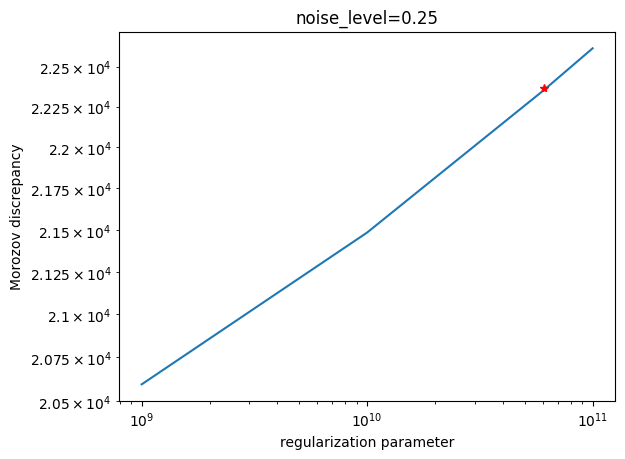

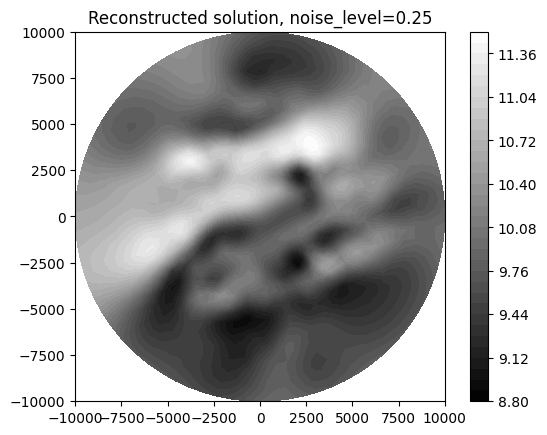

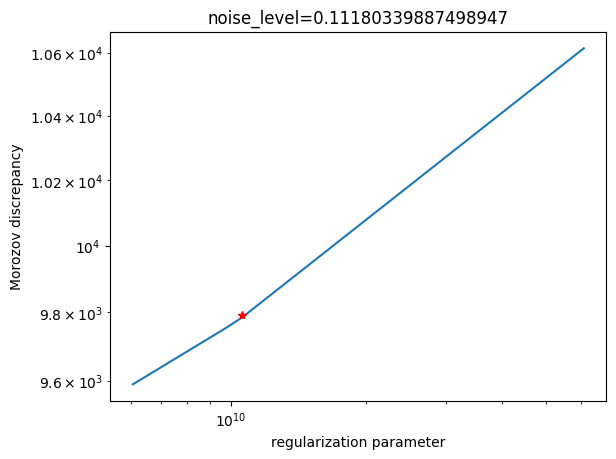

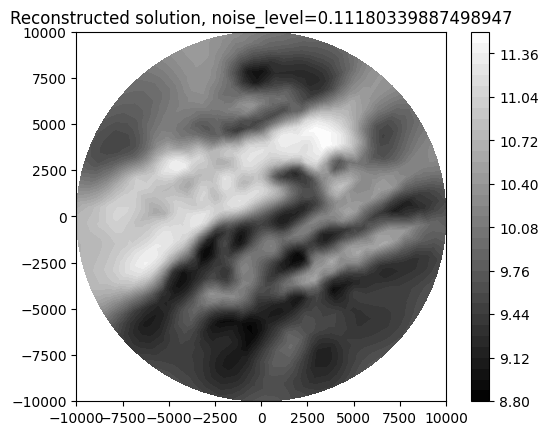

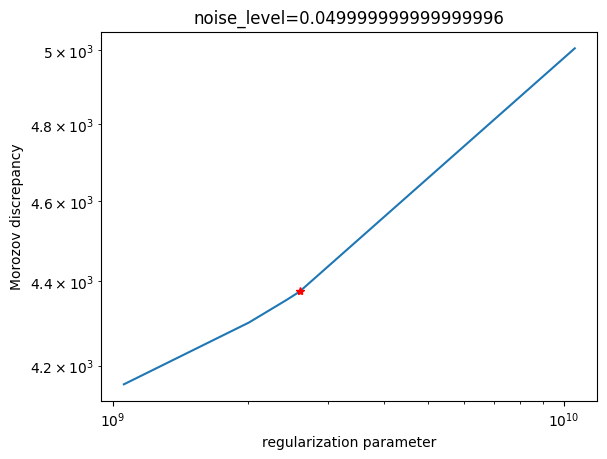

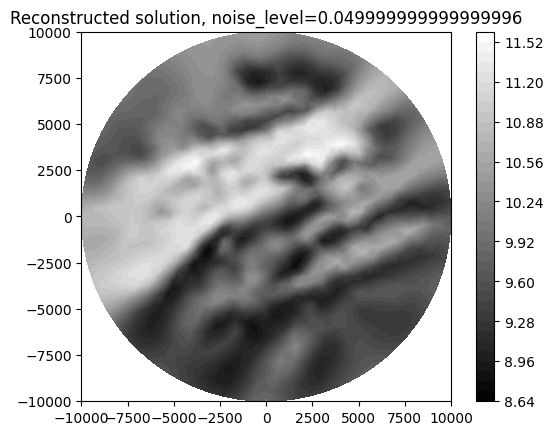

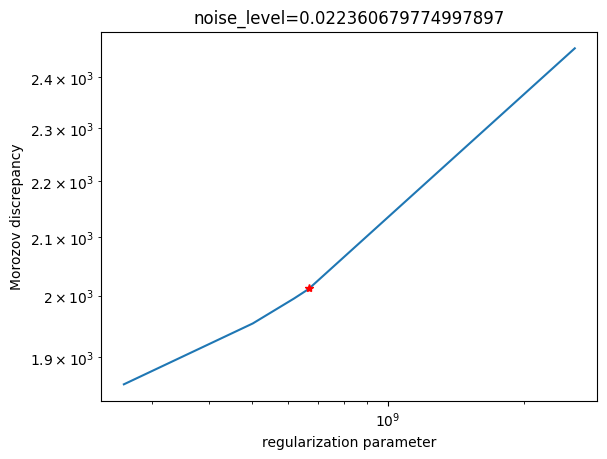

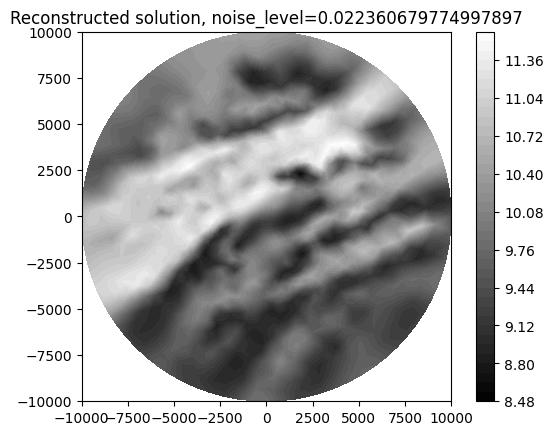

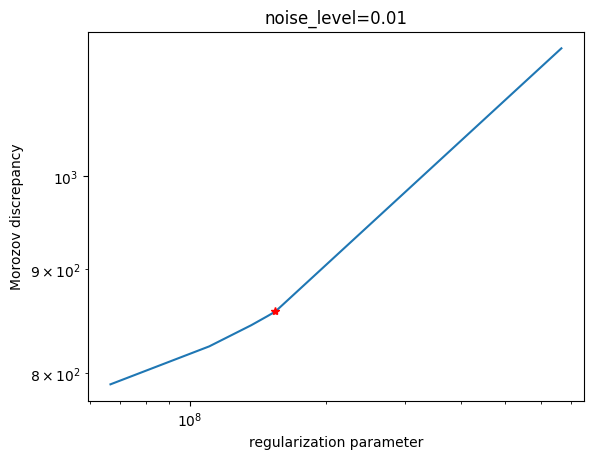

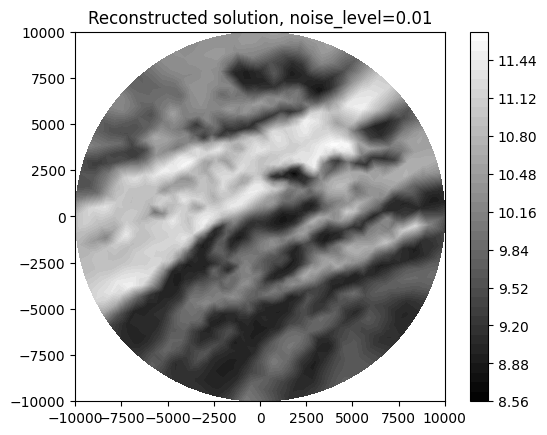

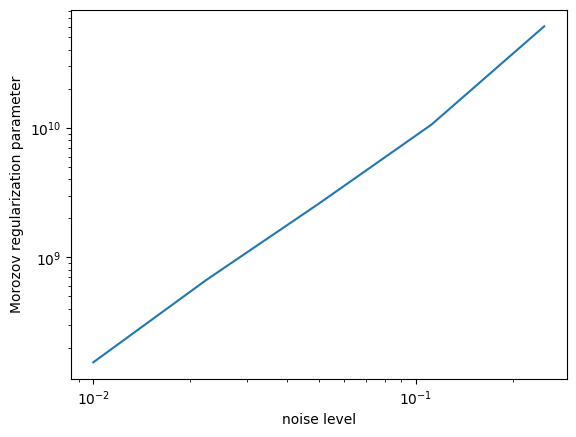

In [15]:
all_noise_vecs = []
all_areg_morozov = []
for noise_level in all_noise_levels:
    noise_vec = SU.unregularized_inverse_problem.generate_multiplicative_noise(noise_level)
    SU.unregularized_inverse_problem.update_noise(noise_vec)
    all_noise_vecs.append(noise_vec)
    
    noise_datanorm = SU.unregularized_inverse_problem.noise_datanorm()
    print('noise_level=', noise_level, 'noise_datanorm=', noise_datanorm)

    if all_areg_morozov:
        areg0 = all_areg_morozov[-1]
    else:
        areg0 = SU.areg_ini
    
    areg_morozov, seen_aregs, seen_discrepancies = SU.compute_morozov_areg(
        areg0, display=True)
    
    all_areg_morozov.append(areg_morozov)
    
    print('noise_level=', noise_level, ', areg_morozov=', areg_morozov)
    inds = np.argsort(seen_aregs)
    plt.figure()
    plt.loglog(seen_aregs[inds], seen_discrepancies[inds])
    plt.loglog(areg_morozov, noise_datanorm, '*r')
    plt.xlabel('regularization parameter')
    plt.ylabel('Morozov discrepancy')
    plt.title('noise_level='+str(noise_level))

    plt.figure()
    cm = dl.plot(SU.unregularized_inverse_problem.m_Vh2(), cmap='gray')
    plt.colorbar(cm)
    plt.title('Reconstructed solution, noise_level=' + str(noise_level))
    
plt.figure()
plt.loglog(all_noise_levels, all_areg_morozov)
plt.xlabel('noise level')
plt.ylabel('Morozov regularization parameter')

In [18]:
np.savetxt(save_dir_str + "/all_noise_vecs", np.array(all_noise_vecs))
np.savetxt(save_dir_str + "/all_noise_levels", np.array(all_noise_levels))
np.savetxt(save_dir_str + "/all_areg_morozov", np.array(all_areg_morozov))

# Solve inverse problem for a variety of noise levels. 

In [27]:
ind=2
noise_level = all_noise_levels[ind]
noise_vec = all_noise_vecs[ind]
areg_morozov = all_areg_morozov[ind]

psf_options = {
    'num_initial_batches' : 5, 'display' : True, 
    'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}

SU.objective.set_optimization_variable(SU.objective.regularization.mu)
SU.psf_preconditioner.current_preconditioning_type = 'none'
SU.psf_preconditioner.psf_options = psf_options

# PSF preconditioning at 5% noise

In [28]:
info5 = SU.solve_inverse_problem(
    areg_morozov,
    forcing_sequence_power=0.5,
    preconditioner_build_iters=(3,),
    num_gn_iter=5,
    newton_rtol=1e-8, 
    display=True)


----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 2595834887.449172
newton_rtol 1e-08
num_gn_iter= 5
preconditioner_build_iters= (3,)
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.949e+07
||M r0|| = 1.949e+07
(M r0, r0) = 1.949e+07
 Iteration :  0  (r, r) =  379958358536982.9
 Iteration :  1  (r, r) =  45451174737887.51
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  6741748.640960111

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g ->

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.71s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.51s                                                                                                                 
    size of LU factor = 5.07 MB
15  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.52s                                                
    size of LU factor = 5.03 MB
21  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.85s                                                
    size of LU factor = 5.02 MB
2  /  50  eigs found        

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297985320.6400642, 2595834887.449172, 32462883118.420067)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 6.013e+01
||M r0|| = 3.409e-04
(M r0, r0) = 1.010e-01
 Iteration :  0  (r, r) =  3615.9388995043682
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297985320.6400642, 2595834887.449172, 32462883118.420067)
 Iteration :  1  (r, r) =  675.5095488986933
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297985320.6400642, 2595834887.449172, 32462883118.420067)
 Iteration :  2  (r, r) =  35.4295526035818
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297985320.6400642, 2595834887.449172, 32462883118.420067)
 Iteration :  3  (r, r) =  2.3488759222503584
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297985320.6400642, 2595834887.449172, 32462883118.420067)
 Iterat

# No preconditioning at 5% noise

In [33]:
SU.objective.set_optimization_variable(SU.objective.regularization.mu)
SU.psf_preconditioner.current_preconditioning_type = 'none'

info5_none = SU.solve_inverse_problem(
    areg_morozov,
    forcing_sequence_power=0.5,
    preconditioner_build_iters=tuple(),
    num_gn_iter=5,
    newton_rtol=1e-8, 
    display=True)


----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 2595834887.449172
newton_rtol 1e-08
num_gn_iter= 5
preconditioner_build_iters= ()
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= () , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.949e+07
||M r0|| = 1.949e+07
(M r0, r0) = 1.949e+07
 Iteration :  0  (r, r) =  379958358536982.9
 Iteration :  1  (r, r) =  45451174737887.51
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  6741748.640960111

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> bui

using Gauss-Newton Hessian
it= 4 , preconditioner_build_iters= () , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.351e+05
||M r0|| = 1.351e+05
(M r0, r0) = 1.351e+05
 Iteration :  0  (r, r) =  18265501346.550125
 Iteration :  1  (r, r) =  12462743900.795769
 Iteration :  2  (r, r) =  13840249461.25802
 Iteration :  3  (r, r) =  13832346551.674774
 Iteration :  4  (r, r) =  13218096833.33244
 Iteration :  5  (r, r) =  13226072397.499252
 Iteration :  6  (r, r) =  10576114465.263426
 Iteration :  7  (r, r) =  13525641130.181335
 Iteration :  8  (r, r) =  15214809940.648373
 Iteration :  9  (r, r) =  9736198555.920017
 Iteration :  10  (r, r) =  7394044547.6021185
 Iteration :  11  (r, r) =  6268989308.407474
 Iteration :  12  (r, r) =  5042175438.252165
 Iteration :  13  (r, r) =  3118027597.6687226
 Iteration :  14  (r, r) =  3165840871.517514
 Iteration :  15  (r, r) =  2711844994.7422414
 Iteration :  16  (r, r) =  1308915591.007

 Iteration :  6  (r, r) =  19499.63917431934
 Iteration :  7  (r, r) =  23153.591603019762
 Iteration :  8  (r, r) =  19724.156675620507
 Iteration :  9  (r, r) =  18210.35601202383
 Iteration :  10  (r, r) =  14428.333679669347
 Iteration :  11  (r, r) =  11827.129708317358
 Iteration :  12  (r, r) =  9355.08573972298
 Iteration :  13  (r, r) =  7656.360402615538
 Iteration :  14  (r, r) =  6342.055298429943
 Iteration :  15  (r, r) =  5672.015286958686
 Iteration :  16  (r, r) =  4844.731694470956
 Iteration :  17  (r, r) =  4350.603449262409
 Iteration :  18  (r, r) =  3473.167724746491
 Iteration :  19  (r, r) =  3148.824647903306
 Iteration :  20  (r, r) =  2546.2903218882975
 Iteration :  21  (r, r) =  2175.2069672797916
 Iteration :  22  (r, r) =  1595.63203993417
 Iteration :  23  (r, r) =  1308.4792908659738
 Iteration :  24  (r, r) =  1105.6219225147368
 Iteration :  25  (r, r) =  765.548780493732
 Iteration :  26  (r, r) =  589.0805702326413
 Iteration :  27  (r, r) =  530.0

 Iteration :  64  (r, r) =  3.243280393943113e-06
 Iteration :  65  (r, r) =  2.4193766507479977e-06
 Iteration :  66  (r, r) =  1.8333734053812983e-06
 Iteration :  67  (r, r) =  1.3279037121537313e-06
 Iteration :  68  (r, r) =  7.777043662505e-07
 Iteration :  69  (r, r) =  6.562482923513537e-07
 Iteration :  70  (r, r) =  5.151076832206471e-07
 Iteration :  71  (r, r) =  3.1368812525241177e-07
 Iteration :  72  (r, r) =  1.987878365982674e-07
 Iteration :  73  (r, r) =  1.6635726083469681e-07
 Iteration :  74  (r, r) =  1.2505637545087616e-07
 Iteration :  75  (r, r) =  1.0618684015245209e-07
 Iteration :  76  (r, r) =  8.706007098214119e-08
 Iteration :  77  (r, r) =  7.738308343936894e-08
 Iteration :  78  (r, r) =  5.309331066814308e-08
 Iteration :  79  (r, r) =  4.0466686618451525e-08
 Iteration :  80  (r, r) =  2.9611223662132677e-08
 Iteration :  81  (r, r) =  2.8525977322354256e-08
 Iteration :  82  (r, r) =  3.316665250214406e-08
 Iteration :  83  (r, r) =  3.4622323473050

# Regularization preconditioning at 5% noise

In [34]:
SU.objective.set_optimization_variable(SU.objective.regularization.mu)
SU.psf_preconditioner.current_preconditioning_type = 'reg'

info5_none = SU.solve_inverse_problem(
    areg_morozov,
    forcing_sequence_power=0.5,
    preconditioner_build_iters=tuple(),
    num_gn_iter=5,
    newton_rtol=1e-8, 
    display=True)


----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 2595834887.449172
newton_rtol 1e-08
num_gn_iter= 5
preconditioner_build_iters= ()
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= () , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.949e+07
||M r0|| = 5.833e+05
(M r0, r0) = 2.585e+06
 Iteration :  0  (r, r) =  379958358536982.9
 Iteration :  1  (r, r) =  148271061026091.2
 Iteration :  2  (r, r) =  97259526195177.44
 Iteration :  3  (r, r) =  67123513989110.06
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  8192894.115580285

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient

 Iteration :  3  (r, r) =  2727462778545.193
 Iteration :  4  (r, r) =  2592585876647.242
 Iteration :  5  (r, r) =  2493669832280.8438
 Iteration :  6  (r, r) =  2424544407658.5576
 Iteration :  7  (r, r) =  2307989838615.187
 Iteration :  8  (r, r) =  2158927882878.059
 Iteration :  9  (r, r) =  2055227462237.5864
 Iteration :  10  (r, r) =  1822423997283.6074
 Iteration :  11  (r, r) =  1779939165155.4106
 Iteration :  12  (r, r) =  1777442084142.379
 Iteration :  13  (r, r) =  1605525135583.7607
 Iteration :  14  (r, r) =  1496791890238.841
 Iteration :  15  (r, r) =  1379121402038.9648
 Iteration :  16  (r, r) =  1332684942355.8882
 Iteration :  17  (r, r) =  1210023139672.559
 Iteration :  18  (r, r) =  1066408792461.7773
 Iteration :  19  (r, r) =  1045156014503.7084
 Iteration :  20  (r, r) =  854856124197.3529
 Iteration :  21  (r, r) =  825280847886.3701
 Iteration :  22  (r, r) =  627396666274.5902
 Iteration :  23  (r, r) =  551154064357.5156
 Iteration :  24  (r, r) =  450

using Hessian
it= 5 , preconditioner_build_iters= () , num_gn_iter= 5 , using_gauss_newton= False
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 7.985e+04
||M r0|| = 2.357e+02
(M r0, r0) = 2.022e+03
 Iteration :  0  (r, r) =  6375336472.974307
 Iteration :  1  (r, r) =  5956747925.293961
 Iteration :  2  (r, r) =  5771962186.897205
 Iteration :  3  (r, r) =  5698098415.865261
 Iteration :  4  (r, r) =  5522335347.685619
 Iteration :  5  (r, r) =  5522596912.479649
 Iteration :  6  (r, r) =  4976806760.763256
 Iteration :  7  (r, r) =  4777679976.618058
 Iteration :  8  (r, r) =  4672503725.221465
 Iteration :  9  (r, r) =  4534238342.677467
 Iteration :  10  (r, r) =  4289845631.96105
 Iteration :  11  (r, r) =  4170387169.671797
 Iteration :  12  (r, r) =  4104849030.8395143
 Iteration :  13  (r, r) =  4096243991.117043
 Iteration :  14  (r, r) =  4047980243.6627097
 Iteration :  15  (r, r) =  3809397158.25967
 Iteration :  16  (r, r) =  3673235141.56808
 Iteration :  17  (

 Iteration :  42  (r, r) =  3187543.0414037113
 Iteration :  43  (r, r) =  3147131.2519055884
 Iteration :  44  (r, r) =  2906542.2815805706
 Iteration :  45  (r, r) =  2838144.0554993516
 Iteration :  46  (r, r) =  2419909.2948614424
 Iteration :  47  (r, r) =  2129311.743185437
 Iteration :  48  (r, r) =  2083823.17377862
 Iteration :  49  (r, r) =  2071862.9020159775
 Iteration :  50  (r, r) =  1784527.3714004154
 Iteration :  51  (r, r) =  1587468.075910629
 Iteration :  52  (r, r) =  1495607.8043009215
 Iteration :  53  (r, r) =  1431655.4452634798
 Iteration :  54  (r, r) =  1388533.8154078838
 Iteration :  55  (r, r) =  1305477.0913326764
 Iteration :  56  (r, r) =  1261485.305314504
 Iteration :  57  (r, r) =  1090822.139394382
 Iteration :  58  (r, r) =  946421.311911342
 Iteration :  59  (r, r) =  886612.0629864798
 Iteration :  60  (r, r) =  889264.7280227696
 Iteration :  61  (r, r) =  726720.011830332
 Iteration :  62  (r, r) =  713564.1600903964
 Iteration :  63  (r, r) =

 Iteration :  52  (r, r) =  274.3252452332291
 Iteration :  53  (r, r) =  257.3319329458399
 Iteration :  54  (r, r) =  252.06844917824833
 Iteration :  55  (r, r) =  236.26806488924765
 Iteration :  56  (r, r) =  234.77910524976602
 Iteration :  57  (r, r) =  226.18766224520783
 Iteration :  58  (r, r) =  183.2144127489458
 Iteration :  59  (r, r) =  183.72670812825186
 Iteration :  60  (r, r) =  148.1242262399575
 Iteration :  61  (r, r) =  142.22643260575632
 Iteration :  62  (r, r) =  121.74436278061123
 Iteration :  63  (r, r) =  118.90832193921992
 Iteration :  64  (r, r) =  111.52925971140473
 Iteration :  65  (r, r) =  103.01667384941308
 Iteration :  66  (r, r) =  98.89310697450287
 Iteration :  67  (r, r) =  95.2271797848079
 Iteration :  68  (r, r) =  92.69607031221945
 Iteration :  69  (r, r) =  90.160581063426
 Iteration :  70  (r, r) =  80.65055155016896
 Iteration :  71  (r, r) =  80.59248816242558
 Iteration :  72  (r, r) =  80.45454802519937
 Iteration :  73  (r, r) = 

# Spectral plots and condition numbers

noise level= 0.25 , areg_morozov= 60708143125.83244

----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 60708143125.83244
newton_rtol 1e-08
num_gn_iter= 5
preconditioner_build_iters= (3,)
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.983e+07
||M r0|| = 1.983e+07
(M r0, r0) = 1.983e+07
 Iteration :  0  (r, r) =  393244867678246.6
 Iteration :  1  (r, r) =  618341508040071.2
 Iteration :  2  (r, r) =  319207534156180.75
 Iteration :  3  (r, r) =  307694081913711.1
 Iteration :  4  (r, r) =  173607648349052.44
 Iteration :  5  (r, r) =  101360528782861.1
 Iteration :  6  (r, r) =  79473977561423.53
Relative/Absolute residual less than tol
Converged in  6  iterations with final norm  8914817.864736415

==

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 11.60s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.54s                                                
    size of LU factor = 5.04 MB
21  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.13s                                                
    size of LU factor = 5.02 MB
3  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.41s                                                
    size of LU factor = 4.96 MB
0  /  50  eigs found                                             

━━ LU factorisation ( rtol

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30361722862.29325, 60708143125.83244, 758688843558.6311)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 5.104e+02
||M r0|| = 1.263e-03
(M r0, r0) = 4.444e-01
 Iteration :  0  (r, r) =  260492.72707363684
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30361722862.29325, 60708143125.83244, 758688843558.6311)
 Iteration :  1  (r, r) =  15731.061185586554
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30361722862.29325, 60708143125.83244, 758688843558.6311)
 Iteration :  2  (r, r) =  125.33943111901056
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30361722862.29325, 60708143125.83244, 758688843558.6311)
 Iteration :  3  (r, r) =  3.13039666696989
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  1.7692927024576488

====================== Begin

using Hessian
it= 9 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost,

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 9  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 18.28s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 24.89s                                                                                                                 
    size of LU factor = 5.43 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.89s                                                
    size of LU factor = 5.07 MB
27  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.96s                                                                ]  22% ETA 14 s (5.63 GB)
    size of LU facto

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30348452140.92626, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 17.05s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 22.87s                                                
    size of LU factor = 5.38 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 22.27s                                                
    size of LU factor = 5.05 MB
21  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 22.88s                                                
    size of LU factor = 5.01 MB
3  /  50  eigs found                                             

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30349492045.18352, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_hig

  0%|          | 0/25 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = 1e-07 )
[========-                               ]  22% ETA 13 s (5.63 GB)ass_lumps_in)
    done in 18.07s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 24.31s                                                
    size of LU factor = 5.36 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 24.16s                                                
    size of LU factor = 5.02 MB
21  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.86s                                                
    size of LU factor = 5.01 MB
3  /  50  eigs found                                             

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (30365267478.608498, 60708143125.83244, 60708143125.83244)
shifted_inverse_interpolation_solve: (mu_low, mu

k=152, res=0.0005315087429609075, err=0.0008464620957119519
k=153, res=0.0005038613713495283, err=0.0007981621684326018
k=154, res=0.00047927807649584614, err=0.0007544242235137562
k=155, res=0.0004637460715140294, err=0.0007123523488199634
k=156, res=0.0005227551636032201, err=0.0006749660253343155
k=157, res=0.0005266766664469328, err=0.0006455501560697574
k=158, res=0.0004727925139368676, err=0.0006087487152141064
k=159, res=0.0004468948914072898, err=0.0005647486937746559
k=160, res=0.00039687427205727403, err=0.000525476313914885
k=161, res=0.00039573050330681084, err=0.0004893000778607253
k=162, res=0.0003740399228209724, err=0.00045173116553442165
k=163, res=0.00034782118269401595, err=0.00041898817701198886
k=164, res=0.00033554478742152876, err=0.0003894886708909376
k=165, res=0.00036586003668627535, err=0.00036748213976309327
k=166, res=0.00031719801646673204, err=0.0003484186985301183
k=167, res=0.00028297121336546876, err=0.0003278777611149112
k=168, res=0.00034073796682893

k=344, res=3.119427290753202e-08, err=4.435753855285002e-08
k=345, res=3.1300060910989396e-08, err=4.223203766309804e-08
k=346, res=3.068081109939886e-08, err=4.013165003637541e-08
k=347, res=3.19980660309788e-08, err=3.875086680576722e-08
k=348, res=2.6460318555548415e-08, err=3.701397306000719e-08
k=349, res=2.2126173557743616e-08, err=3.4946134463458256e-08
k=350, res=2.204626773352959e-08, err=3.285596547835055e-08
k=351, res=2.6492803431648077e-08, err=3.1636489173724e-08
k=352, res=1.9494734944018962e-08, err=3.0272469643416645e-08
k=353, res=2.0003215596723647e-08, err=2.884997513034039e-08
k=354, res=1.8322416799077284e-08, err=2.759064013910415e-08
k=355, res=1.5611152683721374e-08, err=2.6223019060683365e-08
k=356, res=1.423446415478574e-08, err=2.486130101281309e-08
k=357, res=1.6503612684523458e-08, err=2.3640924926703902e-08
k=358, res=1.7649389608456552e-08, err=2.2918553825507244e-08
k=359, res=1.6362286245851713e-08, err=2.2159443004523777e-08
k=360, res=1.5039786788629

k=0, res=1.00378799376509, err=0.9762578999560693
k=1, res=0.9787663257878074, err=0.8971998739132945
k=2, res=0.9645020274267609, err=0.8429588602622022
k=3, res=0.9423346585746262, err=0.7842495257453859
k=4, res=0.8926879358892448, err=0.682237465170554
k=5, res=0.8587291556916958, err=0.6100990196255088
k=6, res=0.8116078723983856, err=0.5452931374848161
k=7, res=0.7743557489551534, err=0.471201651075138
k=8, res=0.6941088028749116, err=0.382121178882542
k=9, res=0.5794318056224158, err=0.2656377583358566
k=10, res=0.49895896892648317, err=0.22648985894771287
k=11, res=0.3890046362840214, err=0.16893304074620974
k=12, res=0.37099521587550177, err=0.16261278447660008
k=13, res=0.34119381730822335, err=0.15391388051402144
k=14, res=0.25469048087560314, err=0.11437183285257488
k=15, res=0.1977996107125741, err=0.0916193822184651
k=16, res=0.1945472163898518, err=0.0883921441562353
k=17, res=0.1606385373524606, err=0.06943421341352658
k=18, res=0.13535387354069464, err=0.05580046163149

noise level= 0.11180339887498947 , areg_morozov= 10586610497.396692

----------------------------------------------------------
Solving deterministic Stokes inverse problem via Newton-CG
areg= 10586610497.396692
newton_rtol 1e-08
num_gn_iter= 5
preconditioner_build_iters= (3,)
gradnorm_ini= 19315448.81652305
----------------------------------------------------------
using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.954e+07
||M r0|| = 1.954e+07
(M r0, r0) = 1.954e+07
 Iteration :  0  (r, r) =  382006517229034.94
 Iteration :  1  (r, r) =  79871486701701.19
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  8937084.91073578

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alp

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 17.64s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.59s                                                
    size of LU factor = 5.04 MB
8  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.95s                                                
    size of LU factor = 5.05 MB
10  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.66s                                                
    size of LU factor = 5.00 MB
0  /  50  eigs found                                             

━━ LU factorisation ( rtol

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.003e+02
||M r0|| = 8.134e-04
(M r0, r0) = 2.755e-01
 Iteration :  0  (r, r) =  40133.640635407595
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
 Iteration :  1  (r, r) =  2049.2754529434
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
 Iteration :  2  (r, r) =  73.2340728338639
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
 Iteration :  3  (r, r) =  6.452681374814066
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
 Iteration :  4

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5295265430.87157, 10586610497.396692, 132343939135.41165)
 Iteration :  6  (r, r) =  1.5799628785071546e-10
Relative/Absolute residual less than tol
Converged in  6  iterations with final norm  1.256965742773905e-05

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.23s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.26s                                                               ]  45% ETA 7 s (5.86 GB)
    size of LU factor = 5.48 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.27s                                                
    size of LU factor = 5.08 MB
13  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.31s                                                
    size of LU factor = 5.09 MB
12  /  50  eigs found                                  

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5292801732.328981, 10586610497.396692, 10586610497.396692)
building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
━━ building H-matrix ( tol = 1e-07 )
    done in 12.06s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.53s                                                
    size of LU factor = 5.39 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 18.31s                                                
    size of LU factor = 5.04 MB
9  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.44s                                                
    size of LU factor = 5.05 MB
10  /  50  eigs found                                            

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5294170254.310973, 10586610497.396692, 10586610497.396692)
building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof

  0%|          | 0/25 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 11.96s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.23s                                                    ]   7% ETA 13 s (5.86 GB)
    size of LU factor = 5.35 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.82s                                                
    size of LU factor = 5.02 MB
4  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.61s                                                
    size of LU factor = 5.03 MB
10  /  50  eigs found                                            

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (5293917071.049383, 10586610497.396692, 10586610497.396692)
shifted_inverse_interpolation_solve: (mu

noise_level= 0.11180339887498947
cond_none= 907.9873611694004
cond_reg= 9185.6505670652
cond_psf1= 1.8510023750317401
cond_psf5= 1.487751321873597
cond_psf25= 1.2694305850912981
cond_none_gn= 930.2475980851319
cond_reg_gn= 9185.6505670652
cond_psf1_gn= 1.8417673719063619
cond_psf5_gn= 1.4590412586076553
cond_psf25_gn= 1.2354623360313215
k=0, res=0.02562249564323459
k=1, res=0.0016598560364680564
k=2, res=9.734611086115055e-05
k=3, res=5.623628743902742e-06
k=4, res=3.434498912207019e-07
k=5, res=1.9190834066750428e-08
k=6, res=1.098250999731636e-09
k=7, res=6.38649477415271e-11
k=8, res=4.4553518083252096e-12
k=9, res=2.813974027890235e-13
k=10, res=1.5767421419318048e-14
k=0, res=0.9560008065731388, err=0.9746838225328913
k=1, res=0.8361322243953393, err=0.9536603640045949
k=2, res=0.699690717810368, err=0.9354517868123537
k=3, res=0.6103669737608054, err=0.9124304515671086
k=4, res=0.579722750802972, err=0.8826584272307276
k=5, res=0.515167511597177, err=0.8529324629311617
k=6, res=0

k=164, res=2.851966800224968e-06, err=4.549105681669977e-06
k=165, res=2.7904935169881613e-06, err=4.165178761070359e-06
k=166, res=2.7966490567728647e-06, err=3.8974706733480045e-06
k=167, res=2.20027553772141e-06, err=3.6490543837996344e-06
k=168, res=2.058669326025824e-06, err=3.369398588768123e-06
k=169, res=2.055941841661929e-06, err=3.1111734015015705e-06
k=170, res=2.0930351214049206e-06, err=2.9450676898706694e-06
k=171, res=1.6225907972150057e-06, err=2.7126437952609973e-06
k=172, res=1.389682666588837e-06, err=2.4822283091989217e-06
k=173, res=1.2791708236627096e-06, err=2.285883259075683e-06
k=174, res=1.4107005870793399e-06, err=2.1558004790297956e-06
k=175, res=1.1324532810068692e-06, err=2.02829942685476e-06
k=176, res=9.709307560731968e-07, err=1.8780409664003031e-06
k=177, res=9.467623575273626e-07, err=1.7413234672454401e-06
k=178, res=1.0609090214221516e-06, err=1.6134122985947514e-06
k=179, res=9.057243701017506e-07, err=1.5103071803084807e-06
k=180, res=7.9791762031

k=0, res=1.0040991427124315, err=0.996973381091198
k=1, res=1.0082639929251052, err=0.9919446607926631
k=2, res=1.0082065191134275, err=0.9777689732023077
k=3, res=1.0053501916134935, err=0.9545782708757997
k=4, res=0.99176267255535, err=0.9068496287957716
k=5, res=0.982427103172993, err=0.883000961931984
k=6, res=0.981542275900951, err=0.865962337505725
k=7, res=0.9710014699208119, err=0.8227515588716119
k=8, res=0.9467345250422009, err=0.7752234109499959
k=9, res=0.9237685809409083, err=0.6906820310715001
k=10, res=0.887996648357122, err=0.6411697754396505
k=11, res=0.8875993791230211, err=0.6362742152811016
k=12, res=0.8361156953174714, err=0.5315467753522054
k=13, res=0.796876952979623, err=0.4627753255310936
k=14, res=0.7321931372225735, err=0.4148646718190746
k=15, res=0.6612831933910265, err=0.3648107815242081
k=16, res=0.6416443304974703, err=0.357814837914412
k=17, res=0.585607584910241, err=0.3223458934235546
k=18, res=0.571821944971459, err=0.30264507631907683
k=19, res=0.56

k=144, res=2.3345015289942975e-05, err=8.906368094243036e-06
k=145, res=2.2493266068217205e-05, err=8.610794708174726e-06
k=146, res=2.122619893445786e-05, err=8.352949086848033e-06
k=147, res=2.0322942350273114e-05, err=7.330956340833176e-06
k=148, res=1.8513547722940957e-05, err=6.277841806210877e-06
k=149, res=1.5207999373149384e-05, err=5.959530852984131e-06
k=150, res=1.476203966105987e-05, err=5.839462189686418e-06
k=151, res=1.3387945720939612e-05, err=5.2880027790180656e-06
k=152, res=1.2303845951239657e-05, err=4.880616589035634e-06
k=153, res=1.2049029798390473e-05, err=4.632718423611143e-06
k=154, res=9.691717826313834e-06, err=3.886908975669572e-06
k=155, res=7.531379037180352e-06, err=2.7630970382165066e-06
k=156, res=7.353372612252095e-06, err=2.741353434940857e-06
k=157, res=7.2152059067668986e-06, err=2.691503797046094e-06
k=158, res=6.871413038424411e-06, err=2.5283928528185986e-06
k=159, res=6.453375911939126e-06, err=2.106851752532161e-06
k=160, res=5.869115051552043

k=292, res=9.376904802540218e-11, err=2.9845674753774003e-11
k=293, res=7.987791727603846e-11, err=2.3373805806899008e-11
k=294, res=7.607199783120765e-11, err=2.1800100286158048e-11
k=295, res=6.47749827004274e-11, err=1.938041356646676e-11
k=296, res=6.082916626680581e-11, err=1.8274470926715718e-11
k=297, res=6.02830519073593e-11, err=1.822358367899309e-11
k=298, res=6.008634961213636e-11, err=1.7897089140454115e-11
k=299, res=5.08794811289799e-11, err=1.6089889772776314e-11
k=300, res=4.960824301170958e-11, err=1.5518524227051135e-11
k=301, res=3.78174661537723e-11, err=1.3922833127541356e-11
k=302, res=3.0857157847390565e-11, err=1.1726578841282447e-11
k=303, res=2.7167021719155908e-11, err=1.0530514799092965e-11
k=304, res=2.666440854832195e-11, err=1.0226503295589209e-11
k=305, res=2.6328540629897802e-11, err=1.0030263909457332e-11
k=306, res=2.5807961582786112e-11, err=9.2381704873355e-12
k=307, res=2.247422515472074e-11, err=7.261272979849361e-12
k=308, res=1.8632365982931044e

using Gauss-Newton Hessian
it= 2 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.541e+06
||M r0|| = 2.541e+06
(M r0, r0) = 2.541e+06
 Iteration :  0  (r, r) =  6454701263859.957
 Iteration :  1  (r, r) =  1724992101882.6426
 Iteration :  2  (r, r) =  1344312441355.3945
 Iteration :  3  (r, r) =  875760116360.821
 Iteration :  4  (r, r) =  461544232204.14246
Relative/Absolute residual less than tol
Converged in  4  iterations with final norm  679370.4675684265

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Do

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.61s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 18.87s                                                
    size of LU factor = 5.08 MB
14  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.32s                                                
    size of LU factor = 5.06 MB
20  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.51s                                                
    size of LU factor = 5.03 MB
2  /  50  eigs found                                             

━━ LU factorisation ( rtol

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297827796.844841, 2595834887.449172, 32448060151.868443)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 7.278e+00
||M r0|| = 1.046e-04
(M r0, r0) = 1.608e-02
 Iteration :  0  (r, r) =  52.96260045473965
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297827796.844841, 2595834887.449172, 32448060151.868443)
 Iteration :  1  (r, r) =  6.401151996896548
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297827796.844841, 2595834887.449172, 32448060151.868443)
 Iteration :  2  (r, r) =  0.5126589277415521
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297827796.844841, 2595834887.449172, 32448060151.868443)
 Iteration :  3  (r, r) =  0.05457865005201953
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297827796.844841, 2595834887.449172, 32448060151.868443)
 Iteration

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)1e-07 )
 ==-                                     ]   7% ETA 11 s (5.91 GB)
    done in 12.36s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.40s                                                                                                               
    size of LU factor = 5.49 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 19.18s                                                
    size of LU factor = 5.18 MB
16  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.33s                                              

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297296214.1908739, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.62s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.16s                                                
    size of LU factor = 5.38 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 18.33s                                                
    size of LU factor = 5.08 MB
13  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 17.91s                                                
    size of LU factor = 5.04 MB
19  /  50  eigs found                                            

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297372340.2222111, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

  0%|          | 0/25 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.33s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 18.59s                                                
    size of LU factor = 5.31 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 17.93s                                                
    size of LU factor = 5.03 MB
11  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.30s                                                
    size of LU factor = 5.02 MB
20  /  50  eigs found                                            

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (1297731684.4907365, 2595834887.449172, 2595834887.449172)
shifted_inverse_interpolation_solve: (mu_low, mu

k=76, res=0.00030809586181027585, err=0.0004860487810629236
k=77, res=0.00029327332509453016, err=0.0004402491304853681
k=78, res=0.000247381143091922, err=0.000403297793907655
k=79, res=0.0002031636570908438, err=0.00036330970867729195
k=80, res=0.00018424881265194262, err=0.0003232804849679123
k=81, res=0.00015919562053923235, err=0.0002878068610148734
k=82, res=0.0001369602421738863, err=0.00025643555486750216
k=83, res=0.00012349609830832864, err=0.0002316636949345651
k=84, res=0.00011139816966679538, err=0.00021063239288541104
k=85, res=0.00011981002346573008, err=0.00019384902894131715
k=86, res=9.821581493870232e-05, err=0.0001811337994868836
k=87, res=9.15446187881221e-05, err=0.00016558169848490467
k=88, res=8.0762230097411e-05, err=0.00015382174469115038
k=89, res=6.926373227301541e-05, err=0.00014070696375988623
k=90, res=5.7749411087626775e-05, err=0.00012690056107596333
k=91, res=5.3555998372374625e-05, err=0.00011432489152374999
k=92, res=4.937022792054014e-05, err=0.0001

k=0, res=0.9960040136786433, err=0.9996193446122583
k=1, res=0.9974245364193971, err=0.9990537516354236
k=2, res=1.000001002194702, err=0.996268218537086
k=3, res=1.0044587334115942, err=0.9851834175084162
k=4, res=1.0097365347412894, err=0.9778304386776787
k=5, res=1.0211935800873597, err=0.9640866321474315
k=6, res=1.0194630897590733, err=0.9465790247304289
k=7, res=1.0454143513052092, err=0.9204035417896829
k=8, res=1.0448609313447015, err=0.8996641974675952
k=9, res=1.048689466574364, err=0.8693621857128327
k=10, res=1.033883283609309, err=0.8241338769813369
k=11, res=1.046003575088468, err=0.8174887253878842
k=12, res=1.0117026182107018, err=0.775114967872081
k=13, res=0.97466280516166, err=0.7398639054911331
k=14, res=0.9794312124191584, err=0.6829285064633592
k=15, res=0.9861901347839526, err=0.6322761749750619
k=16, res=0.9728979460955911, err=0.6205126425928619
k=17, res=0.94236513203072, err=0.5697907715050332
k=18, res=0.938640012295984, err=0.5644329703168804
k=19, res=0.91

k=225, res=0.00027510744714341417, err=8.048890538454151e-05
k=226, res=0.00027088422537581837, err=7.897647809053786e-05
k=227, res=0.00025260238157964835, err=7.382616298517113e-05
k=228, res=0.00022026804613942054, err=6.768059236400091e-05
k=229, res=0.00022115591267930158, err=6.742227297461044e-05
k=230, res=0.000220597494554843, err=6.703681757368598e-05
k=231, res=0.00021978074385949753, err=6.597984688503069e-05
k=232, res=0.00019984486427626765, err=6.167283241566827e-05
k=233, res=0.00018940190131277014, err=5.2030309468804385e-05
k=234, res=0.0001837119768244143, err=5.072021644107689e-05
k=235, res=0.00017563069491139362, err=4.984315205320545e-05
k=236, res=0.00016150276632173773, err=4.559742064535764e-05
k=237, res=0.00015969005172547025, err=4.413696571675044e-05
k=238, res=0.00016042263978359206, err=4.3537668105889073e-05
k=239, res=0.00015578814884338154, err=4.150683952927799e-05
k=240, res=0.00012956911773682979, err=3.6737575455533354e-05
k=241, res=0.00012644311

k=385, res=2.63746104142441e-07, err=7.24427379295009e-08
k=386, res=2.586033394538469e-07, err=7.077406339026207e-08
k=387, res=2.5603776441186066e-07, err=6.786270262091453e-08
k=388, res=2.55269941447872e-07, err=6.655626529407271e-08
k=389, res=2.4289733902841056e-07, err=6.504389832330661e-08
k=390, res=2.3667113920543396e-07, err=6.432066879042937e-08
k=391, res=2.2171620693748604e-07, err=6.311717985322524e-08
k=392, res=1.9877761276794353e-07, err=6.171238944292468e-08
k=393, res=1.9526212064002e-07, err=6.103431051750659e-08
k=394, res=1.9457864499809346e-07, err=6.0758862827255e-08
k=395, res=1.7866527320789966e-07, err=5.566161570124027e-08
k=396, res=1.7728050115254873e-07, err=5.546422654479374e-08
k=397, res=1.7627141543119557e-07, err=5.524621514344832e-08
k=398, res=1.5353623993200597e-07, err=4.0892339668916826e-08
k=399, res=1.3928771257693445e-07, err=3.960048413231378e-08
k=400, res=1.300306933548431e-07, err=3.5966766586721424e-08
k=401, res=1.2251000795698598e-07,

k=539, res=3.8133159909912096e-10, err=1.0012754790851972e-10
k=540, res=3.673565015052099e-10, err=9.703953484411747e-11
k=541, res=3.540901108129189e-10, err=9.488337884214614e-11
k=542, res=3.511995541939315e-10, err=9.398330213452145e-11
k=543, res=3.4936053381325967e-10, err=9.323578820806461e-11
k=544, res=3.022762485506673e-10, err=8.099913166660181e-11
k=545, res=2.967299874540592e-10, err=7.407157076777621e-11
k=546, res=2.5946924812058315e-10, err=6.941628062663488e-11
k=547, res=2.436717904494392e-10, err=6.628298821419067e-11
k=548, res=2.381267634827328e-10, err=6.586584985950283e-11
k=549, res=2.2322823204319933e-10, err=5.862410024529051e-11
k=550, res=2.150974429284887e-10, err=5.836395629632485e-11
k=551, res=2.1299062032738925e-10, err=5.824943210256054e-11
k=552, res=2.0860131856213546e-10, err=5.666099822367036e-11
k=553, res=2.0742176759177097e-10, err=5.610080224700847e-11
k=554, res=2.0478773511465405e-10, err=5.48011492346973e-11
k=555, res=2.067973950379664e-10

k=20, res=3.9112463717583426e-13, err=1.2543032470028267e-13
k=0, res=0.10341323611338119, err=0.04241024618202982
k=1, res=0.024394460221055545, err=0.005224126105827199
k=2, res=0.006149030427516661, err=0.0017448683530740426
k=3, res=0.0015577436954219447, err=0.0003331459577821014
k=4, res=0.00042490215186528294, err=0.00010517420606970856
k=5, res=0.00010405479557456672, err=2.3113062321799973e-05
k=6, res=2.1144415180299465e-05, err=5.1156261904401676e-06
k=7, res=4.775551604144241e-06, err=1.2128785910961035e-06
k=8, res=9.934927741107398e-07, err=2.4958816917921404e-07
k=9, res=2.0930422123168735e-07, err=5.357194896225082e-08
k=10, res=4.5555215288763894e-08, err=1.1858367370007247e-08
k=11, res=1.1881364600545383e-08, err=2.8382698105786734e-09
k=12, res=2.827719413048377e-09, err=6.751048177927351e-10
k=13, res=6.01488475400673e-10, err=1.6044386836373828e-10
k=14, res=1.1542699937743466e-10, err=2.958578650174514e-11
k=15, res=2.6575359486584307e-11, err=6.325015165730955e-

using Gauss-Newton Hessian
it= 3 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
building preconditioner
building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 9  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 12.55s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 18.82s                                                
    size of LU factor = 5.13 MB
25  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 19.10s                                                
    size of LU factor = 5.05 MB
2  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 18.72s                                                
    size of LU factor = 5.04 MB
7  /  50  eigs found                                             

━━ LU factorisation ( rtol

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333343574.4534548, 666775532.9996097, 8331159089.431654)
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 8.205e+01
||M r0|| = 8.801e-04
(M r0, r0) = 1.667e-01
 Iteration :  0  (r, r) =  6732.864780220998
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333343574.4534548, 666775532.9996097, 8331159089.431654)
 Iteration :  1  (r, r) =  1494.5636295399825
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333343574.4534548, 666775532.9996097, 8331159089.431654)
 Iteration :  2  (r, r) =  387.3457067341237
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333343574.4534548, 666775532.9996097, 8331159089.431654)
 Iteration :  3  (r, r) =  36.6653382971305
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333343574.4534548, 666775532.9996097, 8331159089.431654)
 Iteration :  4  (

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)1e-07 )
 ==-                                     ]   7% ETA 15 s (5.99 GB)
    done in 16.73s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 23.02s                                                
    size of LU factor = 5.62 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 22.93s                                                
    size of LU factor = 5.27 MB
35  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.07s                                                
    size of LU factor = 5.11 MB
3  /  50  eigs found        

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333248449.42047244, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 17.06s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 22.82s                                                
    size of LU factor = 5.40 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 22.76s                                                
    size of LU factor = 5.11 MB
23  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.38s                                                
    size of LU factor = 5.04 MB
4  /  50  eigs found                                             

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333550684.66519344, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

  0%|          | 0/25 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 16.90s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 23.24s                                                             
    size of LU factor = 5.29 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.46s                                                
    size of LU factor = 5.03 MB
16  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.25s                                                
    size of LU factor = 5.01 MB
2  /  50  eigs found                                             

━━ LU factoris

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (333488254.62455356, 666775532.9996097, 666775532.9996097)
shifted_inverse_interpolation_solve: (mu_low, mu

k=64, res=0.004652595917600124, err=0.00734603273131213
k=65, res=0.004224420071768707, err=0.006654061539357973
k=66, res=0.004154725024878118, err=0.006040860983639004
k=67, res=0.003455441468694817, err=0.0054979906394684724
k=68, res=0.0030302456602666577, err=0.004975446365490972
k=69, res=0.002559311999851677, err=0.004519472879123447
k=70, res=0.002516231002351578, err=0.004157514324790066
k=71, res=0.0025470314170883126, err=0.0038841360914261443
k=72, res=0.002276970538045755, err=0.0036457036070719514
k=73, res=0.0019332085294217944, err=0.003375258246953581
k=74, res=0.0016862228399750366, err=0.0030569123221026676
k=75, res=0.0015380041390327137, err=0.002790171541754888
k=76, res=0.001340396626256839, err=0.0025238803042384518
k=77, res=0.0012219897026127416, err=0.002305086135841731
k=78, res=0.0015563931196368108, err=0.0021291798814565377
k=79, res=0.0011648266557270181, err=0.002020284660027801
k=80, res=0.001107283083812966, err=0.0018656466422053476
k=81, res=0.00111

k=262, res=3.741972395476961e-11, err=4.551799654116632e-11
k=263, res=2.849766022809564e-11, err=4.1604959121328206e-11
k=264, res=2.5170786071627886e-11, err=3.6386171258098087e-11
k=265, res=2.6266598318236842e-11, err=3.21648604373853e-11
k=266, res=2.484652551226507e-11, err=2.9175017335127626e-11
k=267, res=2.3014128422886344e-11, err=2.6567685887152622e-11
k=268, res=2.191582130327017e-11, err=2.3708779177002674e-11
k=269, res=1.5887545048847313e-11, err=2.125511669616268e-11
k=270, res=1.7243583796194828e-11, err=1.8255144772346427e-11
k=271, res=1.5303118184929937e-11, err=1.6708246640431973e-11
k=272, res=1.2939079558616916e-11, err=1.4514653458796602e-11
k=273, res=1.1330463086723672e-11, err=1.2949677898528356e-11
k=274, res=8.650888569599406e-12, err=1.1097765702472878e-11
k=275, res=1.1759768934210475e-11, err=9.846706863873253e-12
k=276, res=7.302523980031706e-12, err=9.01539198755608e-12
k=277, res=8.16351677795304e-12, err=8.078322650940468e-12
k=278, res=7.66551272568

k=142, res=0.14485155125939156, err=0.05254973371015325
k=143, res=0.14526947543886107, err=0.05230839610232964
k=144, res=0.1353564650797081, err=0.0485519113964453
k=145, res=0.13431096798763473, err=0.04826317354659767
k=146, res=0.13148124102587208, err=0.0467491872301724
k=147, res=0.13293508670620804, err=0.04611594802846412
k=148, res=0.1364373705078884, err=0.0445080221453383
k=149, res=0.12215228512539014, err=0.04171541789411775
k=150, res=0.12364262332396064, err=0.041565813492571775
k=151, res=0.12171118997442965, err=0.03978906070368142
k=152, res=0.11371683183239513, err=0.03896584936749445
k=153, res=0.11187410747916052, err=0.03824177809722172
k=154, res=0.11218647121339162, err=0.03809826064530384
k=155, res=0.10917084073545048, err=0.03719304929250725
k=156, res=0.10217908463023827, err=0.03518147593947411
k=157, res=0.10303993063248079, err=0.034923930726031255
k=158, res=0.09963980968936935, err=0.03460005133576245
k=159, res=0.0997075140386042, err=0.03454542015413

k=293, res=0.005824827635267107, err=0.001659744655533383
k=294, res=0.005381060880698787, err=0.001595772379954865
k=295, res=0.004997667489465463, err=0.0015621661092972419
k=296, res=0.005044978200652867, err=0.0015480969265303964
k=297, res=0.005012651976732001, err=0.0014687382310771468
k=298, res=0.004844864101537097, err=0.0014421755718585253
k=299, res=0.004878599985188725, err=0.0013623798469047654
k=300, res=0.004702928402505263, err=0.001337328841409082
k=301, res=0.0044964894946130755, err=0.0013218559034231918
k=302, res=0.004370006218310415, err=0.001314856370155618
k=303, res=0.004357040717503286, err=0.0012863157315711837
k=304, res=0.004155568771552528, err=0.0012461629448023595
k=305, res=0.004161362283634251, err=0.0012441077813839972
k=306, res=0.004224040802058778, err=0.0012240356758212456
k=307, res=0.004223801492822744, err=0.0011962320741807867
k=308, res=0.003993931685549502, err=0.0011626378345378275
k=309, res=0.00397969475025961, err=0.001143864964952057
k=

k=445, res=0.00022560854842752095, err=6.72001131834208e-05
k=446, res=0.00020645744051750697, err=6.498085473212467e-05
k=447, res=0.00020241347321929342, err=6.492485390435851e-05
k=448, res=0.00019395475725135912, err=6.165762508287452e-05
k=449, res=0.00019308732108572012, err=6.0596191643338386e-05
k=450, res=0.00019753038567866694, err=6.00112597841722e-05
k=451, res=0.00019428163613946888, err=5.8524708621504e-05
k=452, res=0.00019328972646809914, err=5.737251884492743e-05
k=453, res=0.00019652737436272737, err=5.574523824311335e-05
k=454, res=0.00017663904133651242, err=5.3244722239599744e-05
k=455, res=0.00017578534389449315, err=5.3041823500341366e-05
k=456, res=0.00017686705758148075, err=5.262914534353358e-05
k=457, res=0.00017253758414200056, err=5.029849071589251e-05
k=458, res=0.0001718822512242893, err=5.0082831898101925e-05
k=459, res=0.00017308820006981497, err=4.979482201178905e-05
k=460, res=0.00017258490571873402, err=4.959387159229383e-05
k=461, res=0.000171625549

k=592, res=7.776744808684237e-06, err=2.3467187347919693e-06
k=593, res=7.715756146488622e-06, err=2.339724371458541e-06
k=594, res=7.759111335663362e-06, err=2.3203255907634764e-06
k=595, res=8.269562992669548e-06, err=2.2223726163515003e-06
k=596, res=7.842842881863219e-06, err=2.0695740771121437e-06
k=597, res=7.326402164288871e-06, err=2.052628915177212e-06
k=598, res=6.727739683858166e-06, err=1.9461082329074934e-06
k=599, res=6.695232319838778e-06, err=1.9364823255781226e-06
k=600, res=6.663912272021171e-06, err=1.9282000475851523e-06
k=601, res=6.634918831709548e-06, err=1.9197413753265544e-06
k=602, res=6.638433414444588e-06, err=1.8612667459470513e-06
k=603, res=6.663307765313099e-06, err=1.839279971184947e-06
k=604, res=6.048156074155357e-06, err=1.7636144765997622e-06
k=605, res=6.062271505342209e-06, err=1.7580170815236167e-06
k=606, res=6.042631022337889e-06, err=1.7495358835796733e-06
k=607, res=6.009858038713883e-06, err=1.6891672977195273e-06
k=608, res=5.70794735241000

k=744, res=3.1067804774133524e-07, err=9.165644228137528e-08
k=745, res=3.1139930604142507e-07, err=9.10394826415754e-08
k=746, res=3.12161950387915e-07, err=8.969338894718758e-08
k=747, res=3.1012742374735216e-07, err=8.931168005196202e-08
k=748, res=3.208634007708381e-07, err=8.755118097305236e-08
k=749, res=3.1164562433645496e-07, err=8.081851647604935e-08
k=750, res=3.134288010223376e-07, err=8.061978326067353e-08
k=751, res=2.7468409253022795e-07, err=7.63641838433546e-08
k=752, res=2.642541474750092e-07, err=7.558699172723347e-08
k=753, res=2.6528739515714837e-07, err=7.480163363519463e-08
k=754, res=2.530022880105334e-07, err=7.132231668353979e-08
k=755, res=2.46725086818556e-07, err=7.088902334226818e-08
k=756, res=2.4312112666815487e-07, err=7.055344969809296e-08
k=757, res=2.39666111117115e-07, err=6.981996274541133e-08
k=758, res=2.388810802735828e-07, err=6.979331067096208e-08
k=759, res=2.472941833964882e-07, err=6.807440773343945e-08
k=760, res=2.3191475791784343e-07, err

k=892, res=1.29699586638618e-08, err=3.4037355215723942e-09
k=893, res=1.2224571394404202e-08, err=3.3232949973680076e-09
k=894, res=1.20710578965505e-08, err=3.3076468606277154e-09
k=895, res=1.1928284835994269e-08, err=3.248841030842967e-09
k=896, res=1.196787638646473e-08, err=3.245794992652309e-09
k=897, res=1.1304597404309196e-08, err=3.0236016600989053e-09
k=898, res=1.1289083115029808e-08, err=3.0161423319102786e-09
k=899, res=1.1060105003267606e-08, err=2.9710143475536934e-09
k=900, res=1.0691464578683463e-08, err=2.8113153015600688e-09
k=901, res=1.0812298112832713e-08, err=2.7966576835776332e-09
k=902, res=1.0326830002308238e-08, err=2.7189199676591504e-09
k=903, res=1.021212773390574e-08, err=2.6757008125290277e-09
k=904, res=1.0302201458092912e-08, err=2.653910154467295e-09
k=905, res=9.794628541595315e-09, err=2.54506623159535e-09
k=906, res=9.063774583926468e-09, err=2.481867800684091e-09
k=907, res=8.987133743623731e-09, err=2.4699783308461028e-09
k=908, res=8.7881491027

k=1044, res=4.0999408567744443e-10, err=1.2678112310575244e-10
k=1045, res=3.8811548605328717e-10, err=1.245697810831911e-10
k=1046, res=3.844467676195096e-10, err=1.2435213545405569e-10
k=1047, res=3.817230420680803e-10, err=1.2356572673426292e-10
k=1048, res=3.6821027269398056e-10, err=1.2120423434559258e-10
k=1049, res=3.6233151470363014e-10, err=1.2068405406558445e-10
k=1050, res=3.6322264955031684e-10, err=1.1692595400908927e-10
k=1051, res=3.7286241134251194e-10, err=1.1538582979025025e-10
k=1052, res=3.6440025418703666e-10, err=1.1288827862701607e-10
k=1053, res=3.5954719231097596e-10, err=1.1237182899526125e-10
k=1054, res=3.570798081541974e-10, err=1.1158340981599667e-10
k=1055, res=3.541005384850039e-10, err=1.0679526195088588e-10
k=1056, res=3.0879177206760753e-10, err=9.402916290152964e-11
k=1057, res=3.0719293423187687e-10, err=9.349685882545068e-11
k=1058, res=2.904201950497786e-10, err=9.186634758225062e-11
k=1059, res=2.8948186672460137e-10, err=9.039437556084727e-11
k=

k=1196, res=1.5760863540914744e-11, err=4.202525552770552e-12
k=1197, res=1.561302725630874e-11, err=4.190900992429705e-12
k=1198, res=1.540311718319977e-11, err=4.173460596375563e-12
k=1199, res=1.5349431683752395e-11, err=4.1468616265594e-12
k=1200, res=1.3916372294895743e-11, err=3.7887270006630855e-12
k=1201, res=1.3593140923684186e-11, err=3.749504019779436e-12
k=1202, res=1.3514007161262877e-11, err=3.7294016595454785e-12
k=1203, res=1.2824154820931539e-11, err=3.619491713690534e-12
k=1204, res=1.254416075774849e-11, err=3.5931127617434123e-12
k=1205, res=1.2443763612759391e-11, err=3.5712474074520607e-12
k=1206, res=1.229442907371493e-11, err=3.5635649637977138e-12
k=1207, res=1.1998667333345152e-11, err=3.521015756617704e-12
k=1208, res=1.2089569043082121e-11, err=3.500701645044109e-12
k=1209, res=1.2092898382875329e-11, err=3.4876899331914416e-12
k=1210, res=1.2037350168466702e-11, err=3.4020546351383055e-12
k=1211, res=1.2045572165473728e-11, err=3.3145194991403473e-12
k=1212

k=24, res=1.125879329305621e-08, err=3.047444323862887e-09
k=25, res=7.24150839915733e-09, err=1.7420235539602143e-09
k=26, res=3.4671408133829034e-09, err=9.8858288881641e-10
k=27, res=1.6442330510848293e-09, err=4.6393240359080227e-10
k=28, res=7.563706739034639e-10, err=2.1455136882086208e-10
k=29, res=4.410465218046575e-10, err=1.09203790052252e-10
k=30, res=2.3656339298157884e-10, err=7.138137176548886e-11
k=31, res=1.0602448993626332e-10, err=3.2425170368438124e-11
k=32, res=4.748176694004095e-11, err=1.4729535495095624e-11
k=33, res=2.2201204878552686e-11, err=6.150157535007308e-12
k=34, res=9.620584460538618e-12, err=2.853989910729824e-12
k=35, res=4.27988325885372e-12, err=1.1895100111430436e-12
k=36, res=1.8431745868042506e-12, err=4.966894815600218e-13
k=37, res=7.917529428829862e-13, err=2.1159739845570036e-13
k=0, res=0.182840913368653, err=0.13191589089605657
k=1, res=0.05616661088441988, err=0.024301929610102396
k=2, res=0.02232260259768626, err=0.006900060829367903
k=3,

Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 2.372e+06
||M r0|| = 2.372e+06
(M r0, r0) = 2.372e+06
 Iteration :  0  (r, r) =  5624694563240.811
 Iteration :  1  (r, r) =  1749893320248.5657
 Iteration :  2  (r, r) =  1288258423707.4167
 Iteration :  3  (r, r) =  753522108776.21
 Iteration :  4  (r, r) =  373214902083.47815
Relative/Absolute residual less than tol
Converged in  4  iterations with final norm  610913.1706580552

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cos

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
━━ building H-matrix ( tol = 1e-07 )
    done in 17.93s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 24.03s                                                
    size of LU factor = 5.17 MB
38  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 24.00s                                                
    size of LU factor = 5.08 MB
5  /  50  eigs found                                             

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.85s                                                
    size of LU factor = 5.06 MB
15  /  50  eigs found                                            

━━ LU factorisation ( rtol

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  4  (r, r) =  361371.4191808357
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  5  (r, r) =  236858.93947891658
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  6  (r, r) =  97902.37211509363
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  7  (r, r) =  18997.54315981883
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  8  (r, r) =  12005.850592663293
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77398780.67993121, 154831005.42836133, 1934702545.5186512)
 Iteration :  9  (r, r) =  4842.6315049066725
shifted

using Hessian
it= 7 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nHp:     number of Hessian-vector products in Newton iteration
GN:      True (T) if Gauss-Newton Hessian is used, False (F) if Hessian is used
BP:      True (T) if we built or rebuilt the preconditioner, False (F) otherwise.
cost:    cost,

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

building psf object
getting spatially varying volume
stable_division_rtol= 1e-08 , num_unstable / ndof_in= 0  /  1416
getting spatially varying mean
getting spatially varying covariance
postprocessing impulse response moments
finding small volumes. min_vol_rtol= 1e-05
min_vol_rtol= 1e-05 , num_bad_vols / ndof_in= 0  /  1416
finding nearest neighbors to each out dof
computing eigenvalue decompositions of all ellipsoid covariances
finding ellipsoids that have tiny or negative primary axis lengths
num_tiny_Sigmas / ndof_in = 11  /  1416
finding ellipsoids that have primary axis lengths much larger than the domain
num_huge_Sigmas / ndof_in = 0  /  1416
finding ellipsoids that have aspect ratios greater than  20.0
num_bad_aspect_Sigmas / ndof_in = 0  /  1416
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = 1e-07 )
 Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
    done in 17.73s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 23.82s                                                
    size of LU factor = 5.68 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.46s                                                
    size of LU factor = 5.24 MB
50  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.79s                                                
    size of LU factor = 5.19 MB
2  /  50  eigs found                                             
1  /  50  eigs found

━━ LU

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77434435.41248554, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

  0%|          | 0/5 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
━━ building H-matrix ( tol = Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
1e-07 )
    done in 17.28s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 23.73s                                                      ]   7% ETA 19 s (6.08 GB)
    size of LU factor = 5.47 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.35s                                                
    size of LU factor = 5.13 MB
33  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.29s                                                
    size of LU factor = 5.05 MB
14  /  50  eigs found                                          

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77451126.40960972, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

  0%|          | 0/25 [00:00<?, ?it/s]

Using ProductConvolutionKernelRBFColsOnly!
Building hmatrix
Building kernel hmatrix
Computing hmatrix = diag(mass_lumps_out) @ kernel_hmatrix * diag(mass_lumps_in)
━━ building H-matrix ( tol = 1e-07 )
    done in 17.11s                                                
    size of H-matrix = 4.06 MB
                                                                 
━━ LU factorisation ( rtol = 1e-12 )
    done in 23.98s                                                
    size of LU factor = 5.32 MB
                                                                 
━━ LU factorisation ( rtol = 1e-08 )
    done in 23.60s                                                
    size of LU factor = 5.02 MB
27  /  50  eigs found                                            

━━ LU factorisation ( rtol = 1e-08 )
    done in 23.54s                                                
    size of LU factor = 5.01 MB
4  /  50  eigs found                                             

━━ LU factorisation ( rtol 

  0%|          | 0/1415 [00:00<?, ?it/s]

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu

shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
shifted_inverse_interpolation_solve: (mu_low, mu, mu_high)= (77379630.49214047, 154831005.42836133, 154831005.42836133)
noise_level= 0.01
cond_none= 1704.353397707023
cond_reg= 605534.6701886858
cond_psf1= 34.367603933265215
cond_psf5= 53.752820697027964
cond_psf25= 7.064629605099699
cond_none_gn= 1758.7091325111774
cond_reg_gn= 605534.6701886858
cond_psf1_gn= 34.34249049458312
cond_psf5_gn= 53.62

k=118, res=0.001079623490534294, err=0.001173635798448137
k=119, res=0.0008723611395086635, err=0.001130720148361601
k=120, res=0.000732973239259514, err=0.0010758129172980223
k=121, res=0.0007440790826851794, err=0.0010242980263359183
k=122, res=0.0007496080121413314, err=0.000988934704356196
k=123, res=0.0006403747958928556, err=0.0009500234626947416
k=124, res=0.0006877242355969464, err=0.0009129680299475611
k=125, res=0.0006477581706477579, err=0.0008888465622555135
k=126, res=0.0005787456013626975, err=0.0008555573528463226
k=127, res=0.000561845355791584, err=0.0008260748960101328
k=128, res=0.0004572874803292866, err=0.0007930122711723723
k=129, res=0.00048484753615320116, err=0.0007568075474181688
k=130, res=0.0005022709198527211, err=0.0007254170403327938
k=131, res=0.0004133216621450005, err=0.00069785954915979
k=132, res=0.0003815908417525467, err=0.0006619319087137754
k=133, res=0.0004089174237291782, err=0.0006281621147428369
k=134, res=0.0004342424156128216, err=0.0006082

k=332, res=7.160109198763149e-10, err=4.990894024434912e-10
k=333, res=6.207689106019091e-10, err=4.685846066121905e-10
k=334, res=4.993170182394184e-10, err=4.3776950422019186e-10
k=335, res=6.008677488906938e-10, err=4.013100386018956e-10
k=336, res=3.821648494737827e-10, err=3.7345694404429347e-10
k=337, res=3.791356540986367e-10, err=3.341578181204467e-10
k=338, res=3.972300751901053e-10, err=3.1370476195317487e-10
k=339, res=3.641033403186155e-10, err=2.8896474691336e-10
k=340, res=3.952715245023282e-10, err=2.709122537098398e-10
k=341, res=3.153505647374245e-10, err=2.541145406971942e-10
k=342, res=2.4564773482971625e-10, err=2.3199433063926164e-10
k=343, res=3.2271577568186384e-10, err=2.1263063957661647e-10
k=344, res=2.1825074943361204e-10, err=2.0006267190863986e-10
k=345, res=2.526384865920817e-10, err=1.8380623824188139e-10
k=346, res=2.130063797813702e-10, err=1.7501598007157815e-10
k=347, res=2.218423618270692e-10, err=1.5914226647282185e-10
k=348, res=1.9785391746298628e

k=72, res=1.1349029348786661, err=0.5677163370044809
k=73, res=1.119695563813662, err=0.5620823682156392
k=74, res=1.0661075122506771, err=0.5498713099909177
k=75, res=1.100212066410043, err=0.545693869304846
k=76, res=1.052864229101339, err=0.5365869084968136
k=77, res=1.049424773513269, err=0.5359480634190071
k=78, res=1.0132150505082687, err=0.5263445839445346
k=79, res=1.010107027302415, err=0.5246463524905824
k=80, res=1.0221631950208452, err=0.521995095879667
k=81, res=1.0017331781884886, err=0.519356234292864
k=82, res=1.0068013447426056, err=0.514381023411852
k=83, res=1.0066021070324453, err=0.5130726674533735
k=84, res=0.9853143565755772, err=0.4972706410658429
k=85, res=0.988138082311539, err=0.4965510691604418
k=86, res=1.0507248033671819, err=0.4881614835074845
k=87, res=0.9653953086209711, err=0.47825429394201807
k=88, res=0.9868455829650339, err=0.47576488457909505
k=89, res=0.974880883997153, err=0.45983962311880444
k=90, res=0.9824744400605743, err=0.4487155142543024
k

k=226, res=0.2803003093581469, err=0.0909691306524683
k=227, res=0.2811921636840083, err=0.0908198352725906
k=228, res=0.2746156806250643, err=0.08680517893105623
k=229, res=0.27075633743667155, err=0.08648824435297976
k=230, res=0.265843005387409, err=0.08448394207039413
k=231, res=0.26588543176373514, err=0.08407851050489885
k=232, res=0.2678769306904492, err=0.08401273837073979
k=233, res=0.2641222659935495, err=0.08315930968480102
k=234, res=0.2650810390925366, err=0.08259766086945283
k=235, res=0.25926048701561244, err=0.08192421313527984
k=236, res=0.24482080659171468, err=0.07969696309904589
k=237, res=0.24865307169407894, err=0.07932101985047052
k=238, res=0.2485570279852158, err=0.0783386312633021
k=239, res=0.2539397879368899, err=0.07810098803180701
k=240, res=0.2422053697376126, err=0.07507732027523618
k=241, res=0.24207904877907438, err=0.07503107335790138
k=242, res=0.23980214287131918, err=0.07453331525408025
k=243, res=0.22989352527984694, err=0.07405402911897853
k=244,

k=378, res=0.05594917466989242, err=0.01739461783815413
k=379, res=0.056061112979400765, err=0.017382937932271966
k=380, res=0.055274702369716544, err=0.016657740837282647
k=381, res=0.05563119919023491, err=0.016542607083337373
k=382, res=0.05357069468690723, err=0.01636449120203717
k=383, res=0.05263394132784917, err=0.01619580714971919
k=384, res=0.05323806945162276, err=0.016153356522787654
k=385, res=0.05278569257699447, err=0.015792573635320675
k=386, res=0.052534202186440476, err=0.015740370528088122
k=387, res=0.05212379087988924, err=0.015556471757034772
k=388, res=0.05195903154112549, err=0.015525336283449438
k=389, res=0.051492085179022644, err=0.015497169158831727
k=390, res=0.051852027488414144, err=0.015461823567072524
k=391, res=0.051254351964941706, err=0.01494516174413506
k=392, res=0.05024488176411726, err=0.014908884427523833
k=393, res=0.048230045987977754, err=0.014590124029612869
k=394, res=0.04820442209837295, err=0.014534682876874478
k=395, res=0.046424880518651

k=536, res=0.010492821244234767, err=0.0028526171946280797
k=537, res=0.010430401054456155, err=0.0028366340715905674
k=538, res=0.010180621866004075, err=0.002815045236784483
k=539, res=0.010068811967888105, err=0.0028086004614708998
k=540, res=0.010018215618051095, err=0.0028065763516907484
k=541, res=0.01008115455095408, err=0.0027996345194962807
k=542, res=0.010067134104712445, err=0.002771023504918066
k=543, res=0.010078355933366227, err=0.0027687110515649954
k=544, res=0.010027772715649006, err=0.002728325225247469
k=545, res=0.010052623894671585, err=0.002641068179183717
k=546, res=0.009197603143410648, err=0.002505505798398844
k=547, res=0.009259880894056311, err=0.002488905935609785
k=548, res=0.009204935107836565, err=0.0024860120395269743
k=549, res=0.009206543916967574, err=0.0024830686116604304
k=550, res=0.00916206853374392, err=0.0024070955358616287
k=551, res=0.008669767971155696, err=0.002381622796243379
k=552, res=0.008674568682557294, err=0.0023447084062538856
k=553,

k=694, res=0.0018935121323162276, err=0.0005104343712509607
k=695, res=0.0018861134428243974, err=0.0005098799361247776
k=696, res=0.0018234782547896895, err=0.0005018116776821092
k=697, res=0.0017861426279435905, err=0.0004996224861006705
k=698, res=0.0018045307633475273, err=0.0004981007953913932
k=699, res=0.0018426176037225686, err=0.0004931762849180154
k=700, res=0.0018031990831189205, err=0.000490461854091333
k=701, res=0.0017928649730393782, err=0.0004886878765534747
k=702, res=0.001802166439601445, err=0.0004884231737257649
k=703, res=0.0018212155195575983, err=0.0004584774084607875
k=704, res=0.0017684056048107419, err=0.0004565226131428955
k=705, res=0.0017925535515777894, err=0.00045303998381935283
k=706, res=0.0017035910924702766, err=0.000446403983334768
k=707, res=0.0016659265682065982, err=0.0004420769328233555
k=708, res=0.001658327479600789, err=0.00044146054380740104
k=709, res=0.0016380191420140879, err=0.0004368384512276393
k=710, res=0.0016354642043901633, err=0.00

k=848, res=0.00037385000646952203, err=0.00010333168241060265
k=849, res=0.0003481965032070679, err=0.00010213652418956812
k=850, res=0.0003444504813294792, err=0.00010196294019154429
k=851, res=0.0003482726596339766, err=0.00010138038074073802
k=852, res=0.0003486397746392356, err=0.00010109223546543083
k=853, res=0.00036319224112443945, err=9.85224040914085e-05
k=854, res=0.00035538225342211246, err=9.80873131511065e-05
k=855, res=0.0003514275286013655, err=9.762690816866336e-05
k=856, res=0.0003633087912411828, err=9.636309593628124e-05
k=857, res=0.00036000860868403106, err=9.543022647983115e-05
k=858, res=0.0003549981574386127, err=9.425671608256713e-05
k=859, res=0.0003515924026749791, err=9.371640651778093e-05
k=860, res=0.0003439851161882824, err=9.276217954090739e-05
k=861, res=0.00031310127561907914, err=8.995204127219512e-05
k=862, res=0.00030882112263897106, err=8.844781143376068e-05
k=863, res=0.0003095434045701532, err=8.837437754104953e-05
k=864, res=0.000302284459909083

k=1006, res=6.665184776422934e-05, err=1.7592009339878785e-05
k=1007, res=6.639144994769391e-05, err=1.7537949470825186e-05
k=1008, res=6.682075077919902e-05, err=1.740098737022773e-05
k=1009, res=6.563117296516369e-05, err=1.7285573956546845e-05
k=1010, res=6.474565162750238e-05, err=1.7174417246185443e-05
k=1011, res=6.39856693642334e-05, err=1.7094332277077607e-05
k=1012, res=6.306755713409339e-05, err=1.6518706801581767e-05
k=1013, res=6.273047099885308e-05, err=1.6453804551564446e-05
k=1014, res=6.374269439647214e-05, err=1.6323312171741222e-05
k=1015, res=6.24322005717658e-05, err=1.623836566561935e-05
k=1016, res=6.450417905755618e-05, err=1.5996457750075075e-05
k=1017, res=6.36444438182488e-05, err=1.5937437984138395e-05
k=1018, res=6.134609066169539e-05, err=1.550719656591929e-05
k=1019, res=5.670889519014558e-05, err=1.509403915008572e-05
k=1020, res=5.6739840169548645e-05, err=1.5082277946063437e-05
k=1021, res=5.4967325119880945e-05, err=1.474662071808949e-05
k=1022, res=5.

k=1160, res=1.2251524763354156e-05, err=3.4219690021006203e-06
k=1161, res=1.2283748653899054e-05, err=3.4199929877472884e-06
k=1162, res=1.2384840729066746e-05, err=3.4063280469256963e-06
k=1163, res=1.349419962456343e-05, err=3.245396010930766e-06
k=1164, res=1.2274832901898103e-05, err=3.1699502743440457e-06
k=1165, res=1.2423191403087056e-05, err=3.1480919684218826e-06
k=1166, res=1.2276834979035513e-05, err=3.141422309691403e-06
k=1167, res=1.2563977077512282e-05, err=3.0908942821578617e-06
k=1168, res=1.189417560041273e-05, err=3.022482357488005e-06
k=1169, res=1.0912708613827906e-05, err=2.9247308334273303e-06
k=1170, res=1.0873709659558156e-05, err=2.9111151217803864e-06
k=1171, res=1.0571968020293074e-05, err=2.790386622423665e-06
k=1172, res=1.0060545985381879e-05, err=2.77237741445912e-06
k=1173, res=1.0004986496960285e-05, err=2.770382822948908e-06
k=1174, res=9.914551242645968e-06, err=2.7669376731534145e-06
k=1175, res=9.862318343408375e-06, err=2.7635281906323095e-06
k=1

k=1316, res=2.206577103629081e-06, err=5.950354046110104e-07
k=1317, res=2.201933086660671e-06, err=5.928729619062312e-07
k=1318, res=2.204777966138496e-06, err=5.87021696218853e-07
k=1319, res=2.2068813106094247e-06, err=5.867597992740064e-07
k=1320, res=2.2129272533166697e-06, err=5.844080178616833e-07
k=1321, res=2.2595608330863017e-06, err=5.567896612486547e-07
k=1322, res=2.21607645951376e-06, err=5.429587285735086e-07
k=1323, res=2.180472824065215e-06, err=5.409412331258246e-07
k=1324, res=2.1938309978389787e-06, err=5.391062156795329e-07
k=1325, res=2.128261595960479e-06, err=5.322867651382592e-07
k=1326, res=2.098995035633828e-06, err=5.29990151371907e-07
k=1327, res=2.016114186103155e-06, err=5.148149968757202e-07
k=1328, res=1.9578089883957534e-06, err=5.129835720182532e-07
k=1329, res=1.9355940069551688e-06, err=5.092200381352556e-07
k=1330, res=1.9190171053709537e-06, err=5.004141397557099e-07
k=1331, res=1.9150771309749586e-06, err=4.973576865179514e-07
k=1332, res=1.81735

k=1473, res=4.130543406846602e-07, err=1.1514103619781407e-07
k=1474, res=4.103848103439846e-07, err=1.1461673392874584e-07
k=1475, res=4.2180437491332674e-07, err=1.1347529581949563e-07
k=1476, res=3.917611383781448e-07, err=1.1048330360147566e-07
k=1477, res=3.7731277537845585e-07, err=1.0997780813023607e-07
k=1478, res=3.734883479109531e-07, err=1.0946002709547135e-07
k=1479, res=3.6907777904324115e-07, err=1.0910620927720053e-07
k=1480, res=3.69233601764904e-07, err=1.0900911125753948e-07
k=1481, res=3.726802872056915e-07, err=1.0859265942317391e-07
k=1482, res=3.736289013226474e-07, err=1.0852243888035242e-07
k=1483, res=3.7662964833026037e-07, err=1.0728486759385614e-07
k=1484, res=3.9293502269917685e-07, err=1.0331130618252953e-07
k=1485, res=3.9144786029519934e-07, err=1.02890379493441e-07
k=1486, res=3.5107689223326874e-07, err=1.0011731715747953e-07
k=1487, res=3.465901595619878e-07, err=9.960918119668942e-08
k=1488, res=3.313044448273991e-07, err=9.871688514941291e-08
k=1489

k=1629, res=7.523294423256804e-08, err=2.304784014784971e-08
k=1630, res=7.490605455854599e-08, err=2.3035959843139668e-08
k=1631, res=7.468049966282288e-08, err=2.302433663344817e-08
k=1632, res=7.493385829020761e-08, err=2.184894317078321e-08
k=1633, res=7.736743225691383e-08, err=2.1360286206545814e-08
k=1634, res=7.519147901459515e-08, err=2.0962596231870003e-08
k=1635, res=7.290408615010087e-08, err=2.080514762268722e-08
k=1636, res=7.176415626511748e-08, err=2.0743045375977435e-08
k=1637, res=7.133369535299534e-08, err=2.0709281433142792e-08
k=1638, res=7.149363306141276e-08, err=2.0668721071969728e-08
k=1639, res=6.94904121957989e-08, err=2.0418745331500102e-08
k=1640, res=6.808226730489356e-08, err=2.0132964668409975e-08
k=1641, res=6.759109135990185e-08, err=2.011118129048551e-08
k=1642, res=6.333243304536855e-08, err=1.893463148991839e-08
k=1643, res=6.225297793901378e-08, err=1.8843150755597835e-08
k=1644, res=6.196727783903676e-08, err=1.8818715066697214e-08
k=1645, res=6.0

k=1787, res=1.3614029329724503e-08, err=3.908281469814815e-09
k=1788, res=1.3325364916167135e-08, err=3.8777492086713504e-09
k=1789, res=1.3644816260618633e-08, err=3.848078387893037e-09
k=1790, res=1.3978353119370697e-08, err=3.7235028317248496e-09
k=1791, res=1.3388614744266578e-08, err=3.5219932162857043e-09
k=1792, res=1.2591969174951652e-08, err=3.450127865772039e-09
k=1793, res=1.2575408903710959e-08, err=3.4356176541639923e-09
k=1794, res=1.242665244466387e-08, err=3.4300922388103233e-09
k=1795, res=1.1517101085006057e-08, err=3.3637511698442726e-09
k=1796, res=1.139923492155276e-08, err=3.358924586160775e-09
k=1797, res=1.1404886564144009e-08, err=3.3579161938352334e-09
k=1798, res=1.1551336945738451e-08, err=3.328432257601946e-09
k=1799, res=1.1583202842022261e-08, err=3.3196130913639395e-09
k=1800, res=1.1150345480955913e-08, err=3.1996245282498474e-09
k=1801, res=1.100668246869684e-08, err=3.1899702865454602e-09
k=1802, res=1.069894445574004e-08, err=3.165970553567657e-09
k=

k=1941, res=2.753131260125521e-09, err=6.821382659626517e-10
k=1942, res=2.620155137017655e-09, err=6.710219201714325e-10
k=1943, res=2.5068659549595222e-09, err=6.646197870772952e-10
k=1944, res=2.4848843777091926e-09, err=6.641201534646847e-10
k=1945, res=2.5091497800903037e-09, err=6.470649315916331e-10
k=1946, res=2.5227539359210297e-09, err=6.466556905081333e-10
k=1947, res=2.4995697519467578e-09, err=6.454448653959193e-10
k=1948, res=2.3514999189259987e-09, err=6.345190291245125e-10
k=1949, res=2.3222998726728747e-09, err=6.335704319353957e-10
k=1950, res=2.3270498241280934e-09, err=6.187574522311608e-10
k=1951, res=2.3123800126321558e-09, err=6.178946414273878e-10
k=1952, res=2.291331901994622e-09, err=6.105621064080933e-10
k=1953, res=2.2385555191377073e-09, err=6.040162836095691e-10
k=1954, res=2.215459126553672e-09, err=6.0362771607747e-10
k=1955, res=2.20083957930713e-09, err=6.012067219019993e-10
k=1956, res=2.2384083302207717e-09, err=5.973544715708017e-10
k=1957, res=2.20

k=2099, res=4.977939790901158e-10, err=1.2984224000278808e-10
k=2100, res=4.969080375461139e-10, err=1.282896231417539e-10
k=2101, res=4.981232260869835e-10, err=1.2773267040771625e-10
k=2102, res=4.735472620739742e-10, err=1.2315503721621448e-10
k=2103, res=4.502993604587496e-10, err=1.2136955977757798e-10
k=2104, res=4.333593329612226e-10, err=1.1931114693318854e-10
k=2105, res=4.213644725785677e-10, err=1.189791350898168e-10
k=2106, res=4.0371970795774507e-10, err=1.1795583471274272e-10
k=2107, res=4.033449771807204e-10, err=1.1782265494592994e-10
k=2108, res=3.8823905877497596e-10, err=1.1722324393994798e-10
k=2109, res=3.8573930205296916e-10, err=1.1702827362461622e-10
k=2110, res=3.8590670741141907e-10, err=1.1698968130735503e-10
k=2111, res=3.8577527807153785e-10, err=1.1677605481283316e-10
k=2112, res=3.934646224543555e-10, err=1.1558412006972573e-10
k=2113, res=3.870258987537121e-10, err=1.1468301017097931e-10
k=2114, res=4.019637649317207e-10, err=1.1262811643780195e-10
k=211

k=2254, res=8.910860656564851e-11, err=2.6685248008157223e-11
k=2255, res=8.993096261289439e-11, err=2.5654738915669814e-11
k=2256, res=8.768573535108828e-11, err=2.549688054876782e-11
k=2257, res=8.6780021116191e-11, err=2.5407584966464826e-11
k=2258, res=8.75247931902183e-11, err=2.535952761374922e-11
k=2259, res=8.707453624767813e-11, err=2.509613014821001e-11
k=2260, res=8.957251282862412e-11, err=2.4509561931692395e-11
k=2261, res=8.67085457071003e-11, err=2.3862976554413874e-11
k=2262, res=8.788554769274903e-11, err=2.312760877891528e-11
k=2263, res=8.78438770193278e-11, err=2.306693741353343e-11
k=2264, res=8.543585119053885e-11, err=2.2637529631175537e-11
k=2265, res=8.749159861672427e-11, err=2.2465049297003777e-11
k=2266, res=8.157441552570186e-11, err=2.1859409152364055e-11
k=2267, res=8.069761318265892e-11, err=2.1752011676208008e-11
k=2268, res=8.031846354857903e-11, err=2.1715113639021545e-11
k=2269, res=7.460017637274022e-11, err=2.1350795804957148e-11
k=2270, res=7.4363

k=2409, res=1.817937731853009e-11, err=4.495508688985855e-12
k=2410, res=1.8095931387861523e-11, err=4.4840789532537806e-12
k=2411, res=1.7240894184036793e-11, err=4.324159615183241e-12
k=2412, res=1.7012785744805657e-11, err=4.3085718679632815e-12
k=2413, res=1.6974921283014122e-11, err=4.2917006060856065e-12
k=2414, res=1.7018646943222853e-11, err=4.279869653550078e-12
k=2415, res=1.6990410242906077e-11, err=4.220439249895509e-12
k=2416, res=1.6953840291765737e-11, err=4.1830334730973975e-12
k=2417, res=1.6397496595416378e-11, err=4.140947610909782e-12
k=2418, res=1.6696341533564045e-11, err=4.122026653291043e-12
k=2419, res=1.6879727688834582e-11, err=4.050417752302035e-12
k=2420, res=1.4238731543113454e-11, err=3.836411788816985e-12
k=2421, res=1.3900160362690827e-11, err=3.829741577881377e-12
k=2422, res=1.3471952762840343e-11, err=3.785617444095335e-12
k=2423, res=1.3261878340479576e-11, err=3.769646945588293e-12
k=2424, res=1.3298442185125421e-11, err=3.750169713247588e-12
k=242

k=2567, res=2.9070318448344593e-12, err=8.075717250095083e-13
k=2568, res=2.883983995273646e-12, err=8.010937068262325e-13
k=2569, res=2.8835550346214727e-12, err=7.969451322058098e-13
k=2570, res=2.8674568694431293e-12, err=7.948799778914369e-13
k=2571, res=2.832662044054621e-12, err=7.613199006761308e-13
k=2572, res=2.6998422739533415e-12, err=7.528930052256221e-13
k=2573, res=2.692975029017167e-12, err=7.517772167672548e-13
k=2574, res=2.6968099083637997e-12, err=7.512260836313143e-13
k=2575, res=2.5943476626808464e-12, err=7.391434627420131e-13
k=2576, res=2.765315324345784e-12, err=7.235912660366054e-13
k=2577, res=2.786330437674894e-12, err=7.222440763373824e-13
k=2578, res=2.8416155455159945e-12, err=7.080707524482582e-13
k=2579, res=2.820945886940916e-12, err=6.999900412848942e-13
k=2580, res=2.641799373733086e-12, err=6.695149609729132e-13
k=2581, res=2.7051436697576096e-12, err=6.634078730327304e-13
k=2582, res=2.3908929782516185e-12, err=6.409869140447606e-13
k=2583, res=2.3

k=57, res=9.750943357700779e-12, err=1.853128196651616e-12
k=58, res=6.083522184784422e-12, err=1.389993892743449e-12
k=59, res=3.544890475825083e-12, err=8.551805180299361e-13
k=60, res=2.2234802509376374e-12, err=5.258918595034288e-13
k=61, res=1.5623364465898895e-12, err=3.7383417572601984e-13
k=62, res=1.0148021615302496e-12, err=2.263647002297554e-13
k=63, res=7.456768356812389e-13, err=1.5694121196806903e-13
k=0, res=0.4275684581885002, err=0.13127441382794583
k=1, res=0.20480873661853113, err=0.08729927098649748
k=2, res=0.13035908911209718, err=0.04960337255244241
k=3, res=0.0777320864055329, err=0.04035372892026869
k=4, res=0.054626023835298215, err=0.0311732536097872
k=5, res=0.04503632936327758, err=0.02507069008213613
k=6, res=0.04141645840852945, err=0.020792257627371774
k=7, res=0.033627238314057104, err=0.016296736428254674
k=8, res=0.025318261036738905, err=0.011649787015212618
k=9, res=0.018477494544109758, err=0.008219458013498892
k=10, res=0.014141226028571546, err=0

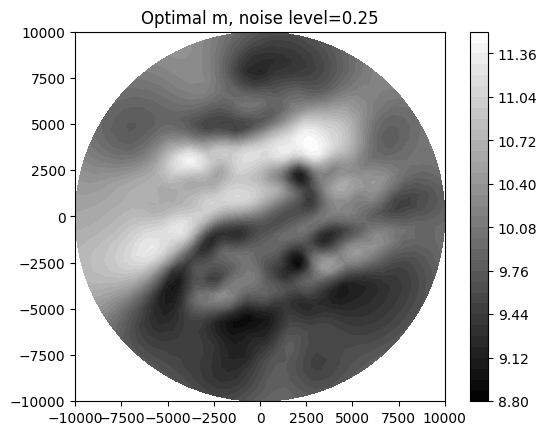

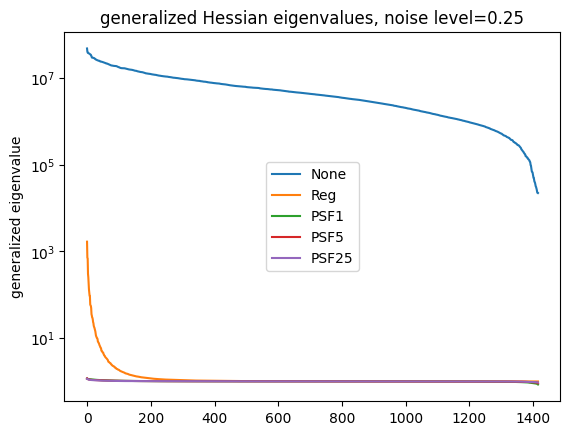

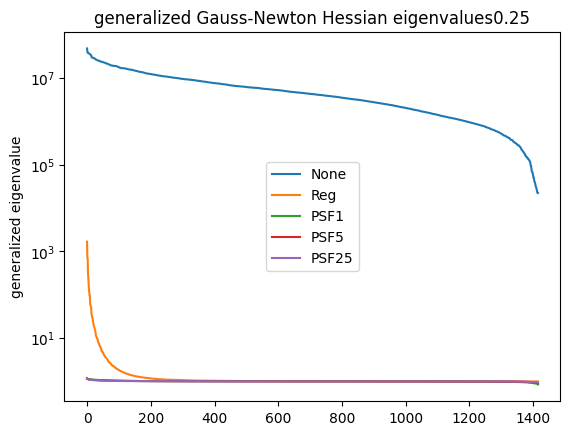

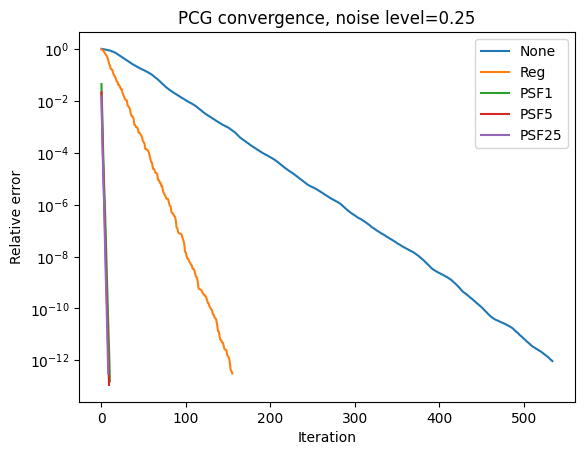

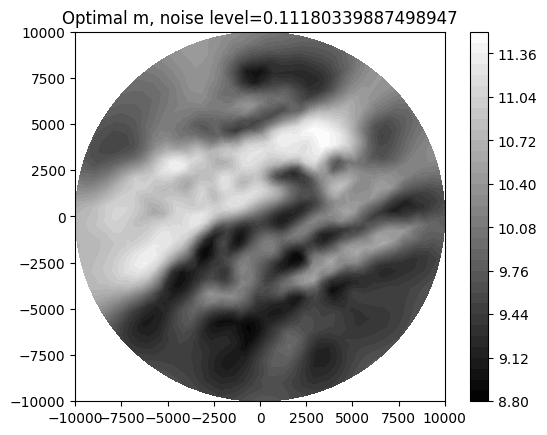

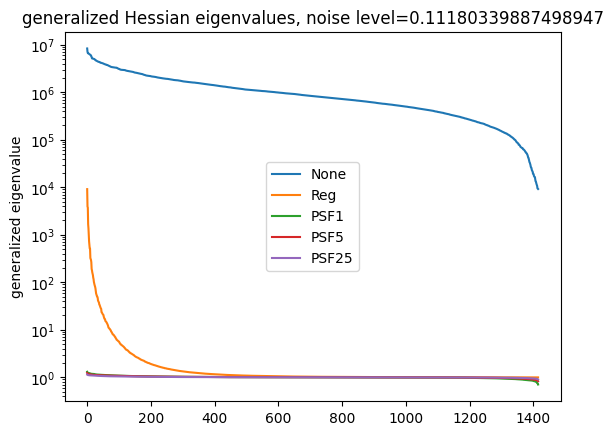

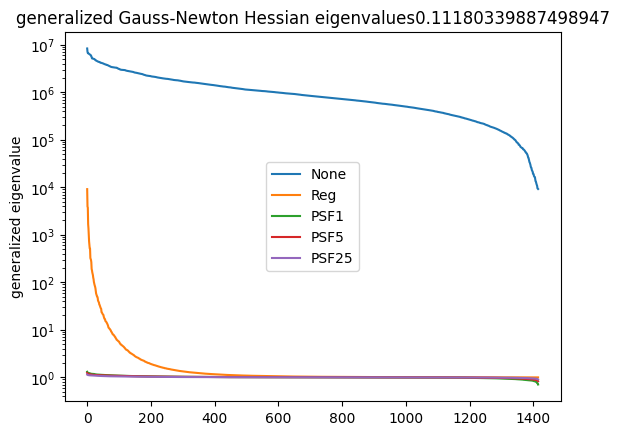

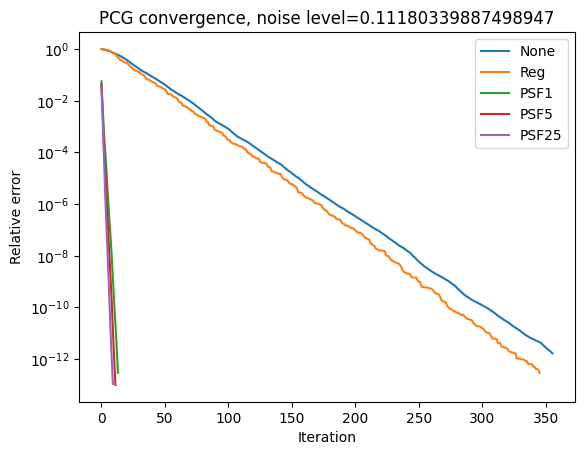

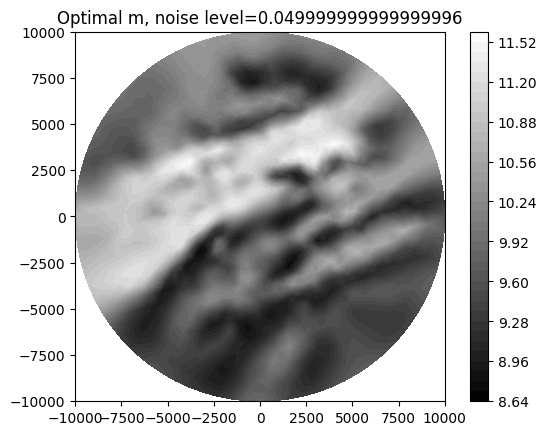

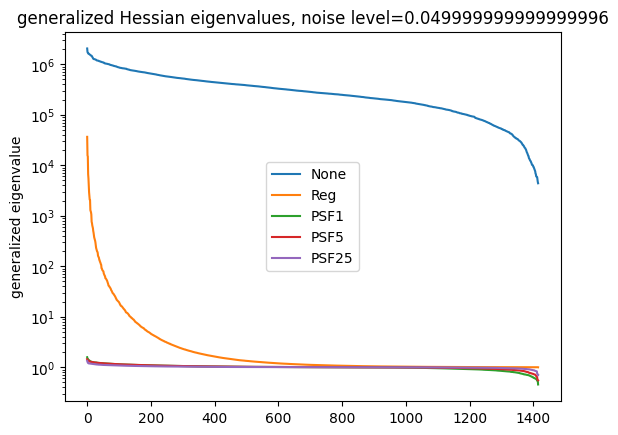

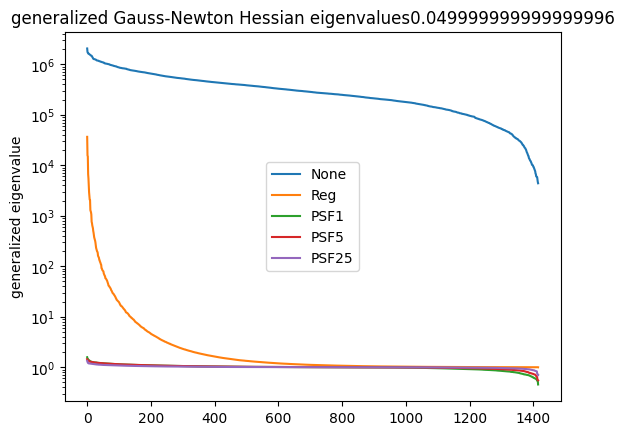

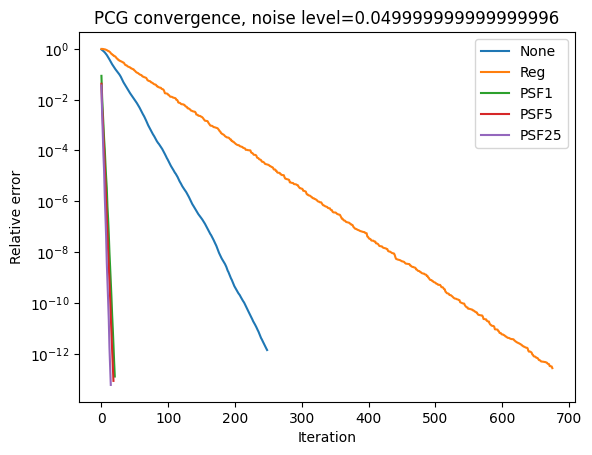

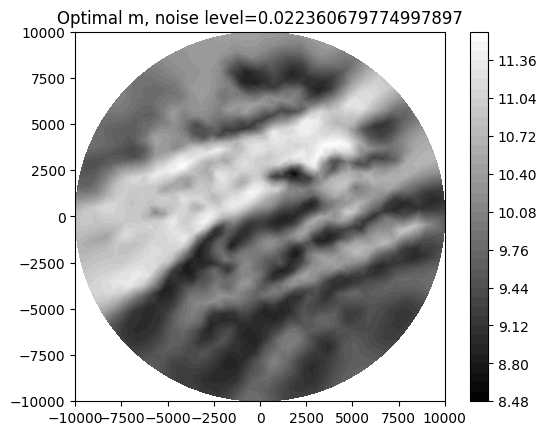

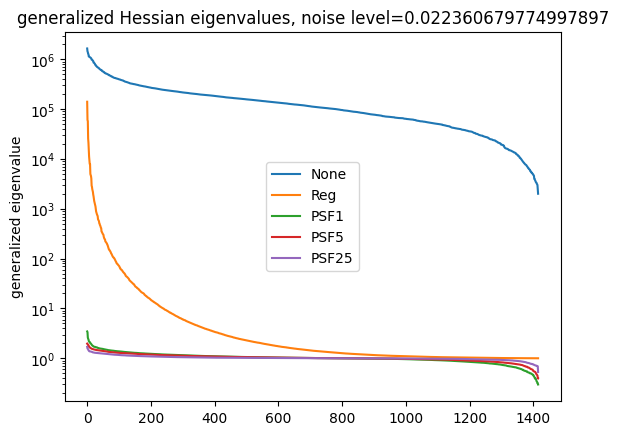

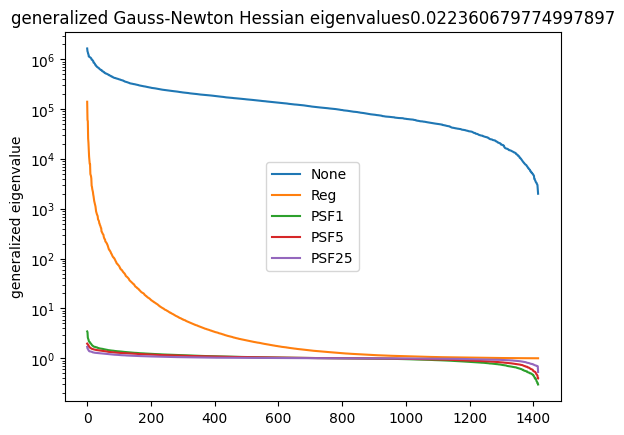

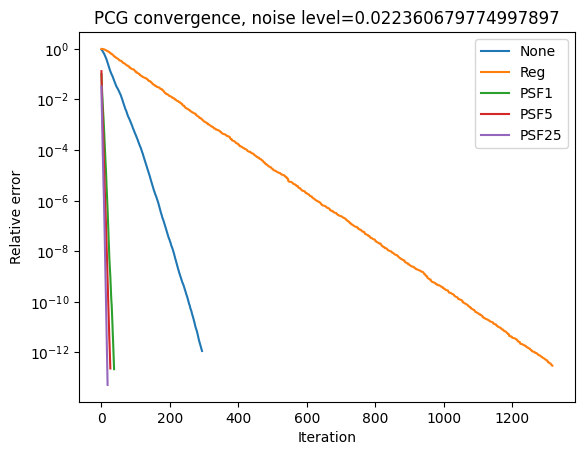

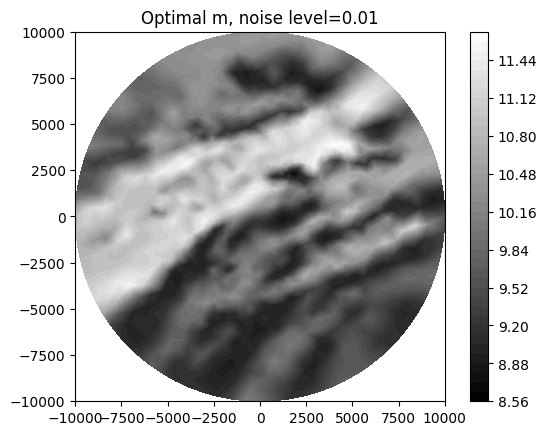

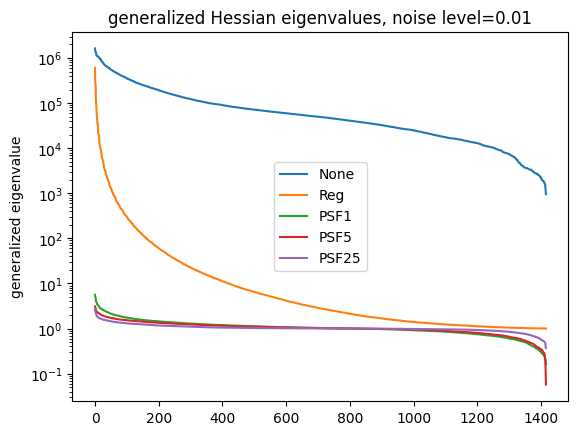

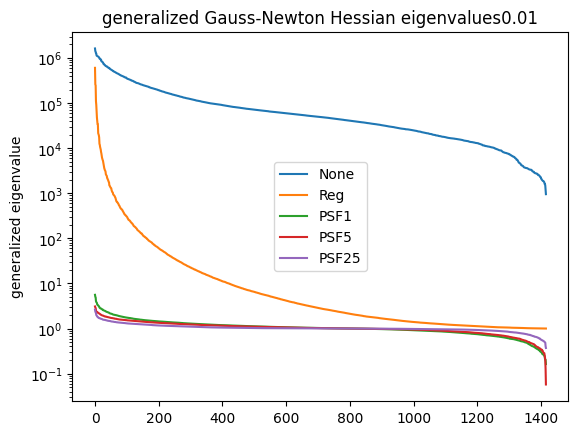

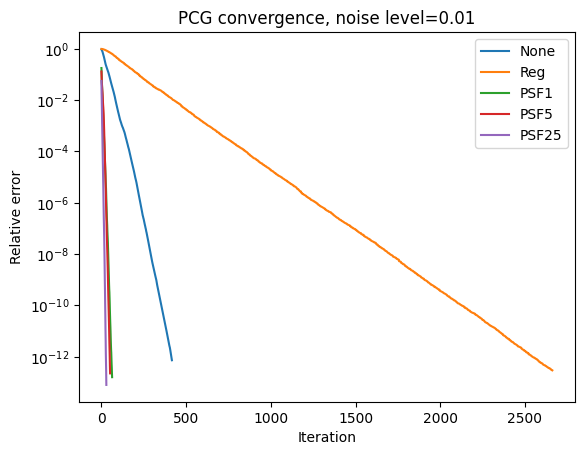

In [132]:
psf_options = {
    'num_initial_batches' : 5, 'display' : True, 
    'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}

all_ncg_info = []

all_mstar = []
all_H_dense = []
all_Hgn_dense = []
all_HR_dense = []
all_Hpsf1_dense = []
all_Hpsf5_dense = []
all_Hpsf25_dense = []

all_ee_none = []
all_ee_none_gn = []
all_ee_reg = []
all_ee_reg_gn = []
all_ee_psf1 = []
all_ee_psf1_gn = []
all_ee_psf5 = []
all_ee_psf5_gn = []
all_ee_psf25 = []
all_ee_psf25_gn = []

all_cond_none = []
all_cond_reg = []
all_cond_psf1 = []
all_cond_psf5 = []
all_cond_psf25 = []

all_cond_none_gn = []
all_cond_reg_gn = []
all_cond_psf1_gn = []
all_cond_psf5_gn = []
all_cond_psf25_gn = []

all_errs_none = []
all_errs_reg = []
all_errs_psf1 = []
all_errs_psf5 = []
all_errs_psf25 = []

for ii in range(len(all_noise_levels)):
    noise_level = all_noise_levels[ii]
    noise_vec = all_noise_vecs[ii]
    areg_morozov = all_areg_morozov[ii]
    
    print('noise level=', noise_level, ', areg_morozov=', areg_morozov)
    
    psf_options = {
        'num_initial_batches' : 5, 'display' : True, 
        'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}
    
    SU.unregularized_inverse_problem.update_noise(noise_vec)

    SU.objective.set_optimization_variable(SU.objective.regularization.mu)
    SU.psf_preconditioner.current_preconditioning_type = 'none'
    SU.psf_preconditioner.psf_options = psf_options
    
    info = SU.solve_inverse_problem(
        areg_morozov,
        forcing_sequence_power=0.5,
        preconditioner_build_iters=(3,),
        num_gn_iter=5,
        newton_rtol=1e-8, 
        display=True)
    
    all_ncg_info.append(info)
    
    N = SU.unregularized_inverse_problem.function_spaces.Vh2.dim()
    mstar = SU.unregularized_inverse_problem.m_Vh2()
    all_mstar.append(mstar)
    
    plt.figure()
    cm = dl.plot(mstar, cmap='gray')
    plt.colorbar(cm)
    plt.title('Optimal m, noise level=' + str(noise_level))
    
    H_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.objective.apply_hessian(x, areg_morozov), N)
    
    Hgn_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.objective.apply_gauss_newton_hessian(x, areg_morozov), N)
    
    HR_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.objective.apply_regularization_hessian(x, areg_morozov), N)
    
    all_H_dense.append(H_dense)
    all_Hgn_dense.append(Hgn_dense)
    all_HR_dense.append(HR_dense)
    
    ee_none, P = sla.eigh(H_dense)
    ee_none_gn, P_gn = sla.eigh(Hgn_dense)
    ee_reg, P_reg = sla.eigh(H_dense, HR_dense)
    ee_reg_gn, P_reg_gn = sla.eigh(H_dense, HR_dense)
    
    all_ee_none.append(ee_none)
    all_ee_none_gn.append(ee_none_gn)
    all_ee_reg.append(ee_reg)
    all_ee_reg_gn.append(ee_reg_gn)
    
    psf_options = {
        'num_initial_batches' : 1, 'display' : True, 
        'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}

    SU.psf_preconditioner.psf_options = psf_options
    SU.psf_preconditioner.build_hessian_preconditioner()
    SU.psf_preconditioner.shifted_inverse_interpolator.display = False
    SU.psf_preconditioner.shifted_inverse_interpolator.insert_new_mu(areg_morozov)
    SU.psf_preconditioner.update_deflation(areg_morozov)

    inv_Hpsf1_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.psf_preconditioner.solve_hessian_preconditioner(x, areg_morozov), N)

    Hpsf1_dense = np.linalg.inv(inv_Hpsf1_dense)
    all_Hpsf1_dense.append(Hpsf1_dense)
    
    psf_options = {
        'num_initial_batches' : 5, 'display' : True, 
        'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}

    SU.psf_preconditioner.psf_options = psf_options
    SU.psf_preconditioner.build_hessian_preconditioner()
    SU.psf_preconditioner.shifted_inverse_interpolator.display = False
    SU.psf_preconditioner.shifted_inverse_interpolator.insert_new_mu(areg_morozov)
    SU.psf_preconditioner.update_deflation(areg_morozov)

    inv_Hpsf5_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.psf_preconditioner.solve_hessian_preconditioner(x, areg_morozov), N)

    Hpsf5_dense = np.linalg.inv(inv_Hpsf5_dense)
    all_Hpsf5_dense.append(Hpsf5_dense)
    
    psf_options = {
        'num_initial_batches' : 25, 'display' : True, 
        'smoothing_width_in': 0.0, 'smoothing_width_out' : 0.0}

    SU.psf_preconditioner.psf_options = psf_options
    SU.psf_preconditioner.build_hessian_preconditioner()
    SU.psf_preconditioner.shifted_inverse_interpolator.display = False
    SU.psf_preconditioner.shifted_inverse_interpolator.insert_new_mu(areg_morozov)
    SU.psf_preconditioner.update_deflation(areg_morozov)

    inv_Hpsf25_dense = build_dense_matrix_from_matvecs(
        lambda x: SU.psf_preconditioner.solve_hessian_preconditioner(x, areg_morozov), N)

    Hpsf25_dense = np.linalg.inv(inv_Hpsf25_dense)
    all_Hpsf25_dense.append(Hpsf25_dense)
    
    ee_psf1, P_psf1 = sla.eigh(H_dense, Hpsf1_dense)
    ee_psf5, P_psf5 = sla.eigh(H_dense, Hpsf5_dense)
    ee_psf25, P_psf25 = sla.eigh(H_dense, Hpsf25_dense)
    
    ee_psf1_gn, P_psf1_gn = sla.eigh(Hgn_dense, Hpsf1_dense)
    ee_psf5_gn, P_psf5_gn = sla.eigh(Hgn_dense, Hpsf5_dense)
    ee_psf25_gn, P_psf25_gn = sla.eigh(Hgn_dense, Hpsf25_dense)
    
    all_ee_psf1.append(ee_psf1)
    all_ee_psf1_gn.append(ee_psf1_gn)
    all_ee_psf5.append(ee_psf5)
    all_ee_psf5_gn.append(ee_psf5_gn)
    all_ee_psf25.append(ee_psf25)
    all_ee_psf25_gn.append(ee_psf25_gn)
    
    plt.figure()
    plt.semilogy(ee_none[::-1])
    plt.semilogy(ee_reg[::-1])
    plt.semilogy(ee_psf1[::-1])
    plt.semilogy(ee_psf5[::-1])
    plt.semilogy(ee_psf25[::-1])
    plt.legend(['None', 'Reg', 'PSF1', 'PSF5', 'PSF25'])
    plt.ylabel('generalized eigenvalue')
    plt.title('generalized Hessian eigenvalues, noise level=' + str(noise_level))
    
    plt.figure()
    plt.semilogy(ee_none[::-1])
    plt.semilogy(ee_reg[::-1])
    plt.semilogy(ee_psf1[::-1])
    plt.semilogy(ee_psf5[::-1])
    plt.semilogy(ee_psf25[::-1])
    plt.legend(['None', 'Reg', 'PSF1', 'PSF5', 'PSF25'])
    plt.ylabel('generalized eigenvalue')
    plt.title('generalized Gauss-Newton Hessian eigenvalues' + str(noise_level))
    
    cond_none = np.max(ee_none) / np.min(ee_none)
    cond_reg = np.max(ee_reg) / np.min(ee_reg)
    cond_psf1 = np.max(ee_psf1) / np.min(ee_psf1)
    cond_psf5 = np.max(ee_psf5) / np.min(ee_psf5)
    cond_psf25 = np.max(ee_psf25) / np.min(ee_psf25)
    
    cond_none_gn = np.max(ee_none_gn) / np.min(ee_none_gn)
    cond_reg_gn = np.max(ee_reg_gn) / np.min(ee_reg_gn)
    cond_psf1_gn = np.max(ee_psf1_gn) / np.min(ee_psf1_gn)
    cond_psf5_gn = np.max(ee_psf5_gn) / np.min(ee_psf5_gn)
    cond_psf25_gn = np.max(ee_psf25_gn) / np.min(ee_psf25_gn)
    print('noise_level=', noise_level)
    print('cond_none=', cond_none)
    print('cond_reg=', cond_reg)
    print('cond_psf1=', cond_psf1)
    print('cond_psf5=', cond_psf5)
    print('cond_psf25=', cond_psf25)
    
    print('cond_none_gn=', cond_none_gn)
    print('cond_reg_gn=', cond_reg_gn)
    print('cond_psf1_gn=', cond_psf1_gn)
    print('cond_psf5_gn=', cond_psf5_gn)
    print('cond_psf25_gn=', cond_psf25_gn)
    
    all_cond_none.append(cond_none)
    all_cond_reg.append(cond_reg)
    all_cond_psf1.append(cond_psf1)
    all_cond_psf5.append(cond_psf5)
    all_cond_psf25.append(cond_psf25)

    all_cond_none_gn.append(cond_none_gn)
    all_cond_reg_gn.append(cond_reg_gn)
    all_cond_psf1_gn.append(cond_psf1_gn)
    all_cond_psf5_gn.append(cond_psf5_gn)
    all_cond_psf25_gn.append(cond_psf25_gn)
    
    b = np.random.randn(N)
    x_true = custom_cg(H_dense, b, M=inv_Hpsf25_dense, tol=1e-13)[0]

    x_none, _, relres_none, errs_none = custom_cg(H_dense, b, x_true=x_true, tol=1e-12)
    x_reg, _, relres_reg, errs_reg = custom_cg(H_dense, b, M=np.linalg.inv(HR_dense), x_true=x_true, tol=1e-12)

    x_psf1, _, relres_psf1, errs_psf1 = custom_cg(H_dense, b, M=inv_Hpsf1_dense, x_true=x_true, tol=1e-12)
    x_psf5, _, relres_psf5, errs_psf5 = custom_cg(H_dense, b, M=inv_Hpsf5_dense, x_true=x_true, tol=1e-12)
    x_psf25, _, relres_psf25, errs_psf25 = custom_cg(H_dense, b, M=inv_Hpsf25_dense, x_true=x_true, tol=1e-12)

    all_errs_none.append(errs_none)
    all_errs_reg.append(errs_reg)
    all_errs_psf1.append(errs_psf1)
    all_errs_psf5.append(errs_psf5)
    all_errs_psf25.append(errs_psf25)
    
    plt.figure()
    plt.semilogy(errs_none)
    plt.semilogy(errs_reg)
    plt.semilogy(errs_psf1)
    plt.semilogy(errs_psf5)
    plt.semilogy(errs_psf25)
    plt.legend(['None', 'Reg', 'PSF1', 'PSF5', 'PSF25'])
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.title('PCG convergence, noise level=' + str(noise_level))

In [160]:
for noise_level, errs_none in zip(all_noise_levels, all_errs_none):
    np.savetxt(save_dir_str + "/errs_none_"+str(noise_level), np.array(errs_none))

In [161]:
for noise_level, errs_reg in zip(all_noise_levels, all_errs_reg):
    np.savetxt(save_dir_str + "/errs_reg_"+str(noise_level), np.array(errs_reg))

In [162]:
for noise_level, errs_psf1 in zip(all_noise_levels, all_errs_psf1):
    np.savetxt(save_dir_str + "/errs_psf1_"+str(noise_level), np.array(errs_psf1))

In [163]:
for noise_level, errs_psf5 in zip(all_noise_levels, all_errs_psf5):
    np.savetxt(save_dir_str + "/errs_psf5_"+str(noise_level), np.array(errs_psf5))

In [164]:
for noise_level, errs_psf25 in zip(all_noise_levels, all_errs_psf25):
    np.savetxt(save_dir_str + "/errs_psf25_"+str(noise_level), np.array(errs_psf25))

0.049999999999999996


Text(0.5, 1.0, 'PCG convergence, noise level=0.049999999999999996')

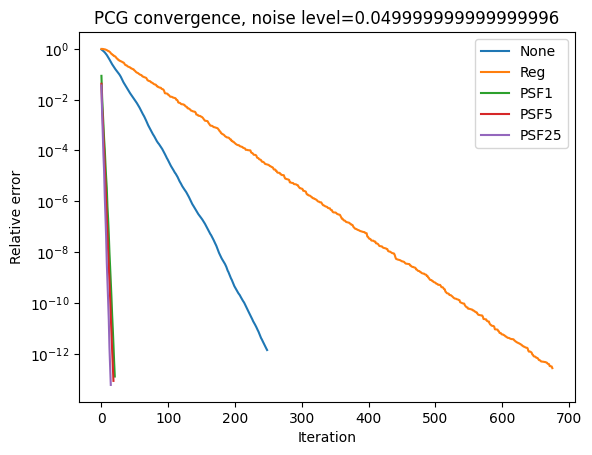

In [154]:
print(all_noise_levels[2])

plt.figure()
plt.semilogy(all_errs_none[2])
plt.semilogy(all_errs_reg[2])
plt.semilogy(all_errs_psf1[2])
plt.semilogy(all_errs_psf5[2])
plt.semilogy(all_errs_psf25[2])
plt.legend(['None', 'Reg', 'PSF1', 'PSF5', 'PSF25'])
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.title('PCG convergence, noise level=' + str(all_noise_levels[2]))

0.049999999999999996


Text(0.5, 1.0, 'generalized Hessian eigenvalues, noise level=0.01')

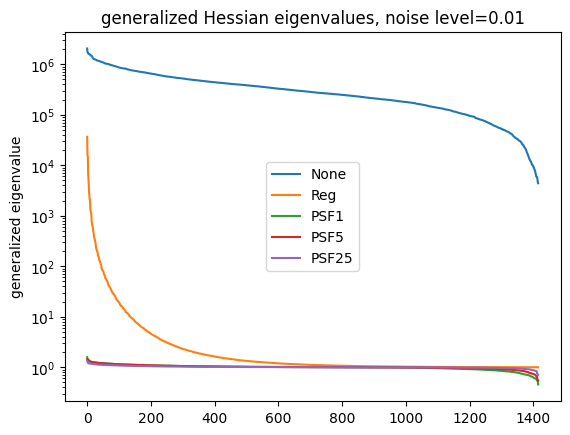

In [166]:
print(all_noise_levels[2])

plt.figure()
plt.semilogy(all_ee_none[2][::-1])
plt.semilogy(all_ee_reg[2][::-1])
plt.semilogy(all_ee_psf1[2][::-1])
plt.semilogy(all_ee_psf5[2][::-1])
plt.semilogy(all_ee_psf25[2][::-1])
plt.legend(['None', 'Reg', 'PSF1', 'PSF5', 'PSF25'])
plt.ylabel('generalized eigenvalue')
plt.title('generalized Hessian eigenvalues, noise level=' + str(noise_level))

In [168]:
for noise_level, ee_none in zip(all_noise_levels, all_ee_none):
    np.savetxt(save_dir_str + "/ee_none_"+str(noise_level), np.array(ee_none[::-1]))

In [169]:
for noise_level, ee_reg in zip(all_noise_levels, all_ee_reg):
    np.savetxt(save_dir_str + "/ee_reg_"+str(noise_level), np.array(ee_reg[::-1]))

In [170]:
for noise_level, ee_psf1 in zip(all_noise_levels, all_ee_psf1):
    np.savetxt(save_dir_str + "/ee_psf1_"+str(noise_level), np.array(ee_psf1[::-1]))

In [171]:
for noise_level, ee_psf5 in zip(all_noise_levels, all_ee_psf5):
    np.savetxt(save_dir_str + "/ee_psf5_"+str(noise_level), np.array(ee_psf5[::-1]))

In [172]:
for noise_level, ee_psf25 in zip(all_noise_levels, all_ee_psf25):
    np.savetxt(save_dir_str + "/ee_psf25_"+str(noise_level), np.array(ee_psf25[::-1]))

In [140]:
for noise_level, mstar in zip(all_noise_levels, all_mstar):
    dl.File(save_dir_str + "/mstar_"+str(noise_level)+".pvd") << mstar

In [165]:
np.savetxt(save_dir_str + "/all_cond_none", np.array(all_cond_none))
np.savetxt(save_dir_str + "/all_cond_reg", np.array(all_cond_reg))
np.savetxt(save_dir_str + "/all_cond_psf1", np.array(all_cond_psf1))
np.savetxt(save_dir_str + "/all_cond_psf5", np.array(all_cond_psf5))
np.savetxt(save_dir_str + "/all_cond_psf25", np.array(all_cond_psf25))

In [138]:
print('all_noise_levels=', all_noise_levels)
print('all_cond_none=', all_cond_none)
print('all_cond_reg=', all_cond_reg)
print('all_cond_psf1=', all_cond_psf1)
print('all_cond_psf5=', all_cond_psf5)
print('all_cond_psf25=', all_cond_psf25)

print(np.array([all_noise_levels, 
                all_cond_none, 
                all_cond_reg, 
                all_cond_psf1, 
                all_cond_psf5, 
                all_cond_psf25]))

all_noise_levels= [0.25, 0.11180339887498947, 0.049999999999999996, 0.022360679774997897, 0.01]
all_cond_none= [2164.7154403069403, 907.9873611694004, 466.85749317358125, 824.9928608045537, 1704.353397707023]
all_cond_reg= [1680.2246405040528, 9185.6505670652, 36566.906220845995, 141373.58752566043, 605534.6701886858]
all_cond_psf1= [1.3689046600514896, 1.8510023750317401, 3.461691746827892, 11.60874713219904, 34.367603933265215]
all_cond_psf5= [1.2991942080880001, 1.487751321873597, 2.6230310442942564, 4.991074253221435, 53.752820697027964]
all_cond_psf25= [1.2135307589579358, 1.2694305850912981, 1.906056823310233, 3.2033354356554766, 7.064629605099699]
[[2.50000000e-01 1.11803399e-01 5.00000000e-02 2.23606798e-02
  1.00000000e-02]
 [2.16471544e+03 9.07987361e+02 4.66857493e+02 8.24992861e+02
  1.70435340e+03]
 [1.68022464e+03 9.18565057e+03 3.65669062e+04 1.41373588e+05
  6.05534670e+05]
 [1.36890466e+00 1.85100238e+00 3.46169175e+00 1.16087471e+01
  3.43676039e+01]
 [1.29919421e+00 

In [ ]:
raise RuntimeError